In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import math
import statsmodels.api as sm
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec

## Importing the fluorescence data

In [11]:
# Importing the mapping of mutant_id to genotypes
mapping_df = pd.read_csv('Val_mutants_cytometry/genotypes_mapping.csv', index_col=None)
# Importing the plan of plate 1
plate1_df = pd.read_csv('Val_mutants_cytometry/plate_1.csv', index_col=None)
# Importing the plan of plate 2
plate2_df = pd.read_csv('Val_mutants_cytometry/plate_2.csv', index_col=None)

In [12]:
# Generating a dictionary of mutant_id -> Genotype mappings
id_to_gen = {mapping_df.at[row_num, 'mutant_id']: (mapping_df.at[row_num, 'Genotype'], mapping_df.at[row_num, 'T_insertion']) for row_num in range(mapping_df.shape[0])}

In [13]:
fluo_model = pd.DataFrame(columns=['Plate', 'Well', 'mutant_id', 'Genotype', 'T_insertion', 'replicate',
                                   "FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"])
fluo_df_1 = fluo_model.copy()

# Iteratively filling the dataframe with plate 1 data
plate1_path = "Val_mutants_cytometry/Cytometry_AKD_25-04-23/2025-04-23_at_01-25-01pm"

for row_num in range(plate1_df.shape[0]):
    well_id = plate1_df.at[row_num, 'Well']
    mutant_id = plate1_df.at[row_num, 'mutant_id']
    genotype = id_to_gen[mutant_id][0]
    t_insert = id_to_gen[mutant_id][1]
    rep_num = plate1_df.at[row_num, 'replicate']

    data_cyto = pd.read_csv(f'{plate1_path}/2025-04-23_at_01-25-01pm.{well_id}.csv')[["FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"]]

    data_cyto['Plate'] = 1
    data_cyto['Well'] = well_id
    data_cyto['mutant_id'] = mutant_id
    data_cyto['Genotype'] = genotype
    data_cyto['T_insertion'] = t_insert
    data_cyto['replicate'] = rep_num

    if row_num == 0:
        fluo_df_1 = data_cyto.copy()

    else:
        fluo_df_1 = pd.concat([fluo_df_1, data_cyto]).reset_index(drop=True)

In [14]:
# Repeating the same thing for plate 2 (which will be normalized separately)
fluo_df_2 = fluo_model.copy()
# Iteratively filling the dataframe with plate 1 data
plate2_path = "Val_mutants_cytometry/Cytometry_AKD_25-04-23/2025-04-23_at_12-56-50pm"

for row_num in range(plate2_df.shape[0]):
    well_id = plate2_df.at[row_num, 'Well']
    mutant_id = plate2_df.at[row_num, 'mutant_id']
    genotype = id_to_gen[mutant_id][0]
    t_insert = id_to_gen[mutant_id][1]
    rep_num = plate2_df.at[row_num, 'replicate']

    data_cyto = pd.read_csv(f'{plate2_path}/2025-04-23_at_12-56-50pm.{well_id}.csv')[["FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"]]

    data_cyto['Plate'] = 2
    data_cyto['Well'] = well_id
    data_cyto['mutant_id'] = mutant_id
    data_cyto['Genotype'] = genotype
    data_cyto['T_insertion'] = t_insert
    data_cyto['replicate'] = rep_num

    if row_num == 0:
        fluo_df_2 = data_cyto.copy()

    else:
        fluo_df_2 = pd.concat([fluo_df_2, data_cyto]).reset_index(drop=True)


## Normalizing and aggregating the fluorescence intensities

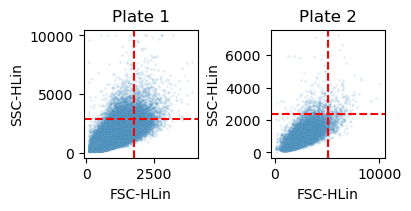

In [16]:
# Establising FSC and SSC thresholds to be applied on each plate
fsc_1 = np.percentile(fluo_df_1['FSC-HLin'], 99)
ssc_1 = np.percentile(fluo_df_1['SSC-HLin'], 99)

fsc_2 = np.percentile(fluo_df_2['FSC-HLin'], 99)
ssc_2 = np.percentile(fluo_df_2['SSC-HLin'], 99)

# Validating the thresholds
fig, axs = plt.subplots(1, 2, figsize=(4,2), constrained_layout=True) 
sns.scatterplot(data=fluo_df_1, x='FSC-HLin', y='SSC-HLin', alpha=0.15, s=3, ax=axs[0])
axs[0].set_title('Plate 1')
axs[0].axhline(y=ssc_1, c='red', linestyle='--')
axs[0].axvline(x=fsc_1, c='red', linestyle='--')


sns.scatterplot(data=fluo_df_2, x='FSC-HLin', y='SSC-HLin', alpha=0.15, s=3, ax=axs[1])
axs[1].set_title('Plate 2')
axs[1].axhline(y=ssc_2, c='red', linestyle='--')
axs[1].axvline(x=fsc_2, c='red', linestyle='--')

In [17]:
print(f'FSC-1 = {fsc_1}; SSC-1 = {ssc_1}')

FSC-1 = 1771.67463332; SSC-1 = 2894.3060766000003


In [18]:
print(f'FSC-2 = {fsc_2}; SSC-2 = {ssc_2}')

FSC-2 = 5040.236909460001; SSC-2 = 2384.8321675400007


There is clearly something weird about plate 2, so the thresholds from plate 1 will be applied to both 

In [20]:
# Applying the thresholds above
fluo_df_1 = fluo_df_1[(fluo_df_1['FSC-HLin'] < fsc_1) & (fluo_df_1['SSC-HLin'] < ssc_1)].copy().reset_index(drop=True)
fluo_df_2 = fluo_df_2[(fluo_df_2['FSC-HLin'] < fsc_1) & (fluo_df_2['SSC-HLin'] < ssc_1)].copy().reset_index(drop=True)

# Dividing by the FSC
fluo_df_1['GRN-B-HLin'] = fluo_df_1['GRN-B-HLin'] / fluo_df_1['FSC-HLin']
fluo_df_1['YEL-B-HLin'] = fluo_df_1['YEL-B-HLin'] / fluo_df_1['FSC-HLin']

fluo_df_2['GRN-B-HLin'] = fluo_df_2['GRN-B-HLin'] / fluo_df_2['FSC-HLin']
fluo_df_2['YEL-B-HLin'] = fluo_df_2['YEL-B-HLin'] / fluo_df_2['FSC-HLin']

# Genrating log10-scaled columns
fluo_df_1['Log10_GRN'] = np.log10(fluo_df_1['GRN-B-HLin'])
fluo_df_1['Log10_YEL'] = np.log10(fluo_df_1['YEL-B-HLin'])

fluo_df_2['Log10_GRN'] = np.log10(fluo_df_2['GRN-B-HLin'])
fluo_df_2['Log10_YEL'] = np.log10(fluo_df_2['YEL-B-HLin'])

F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Are there any outliers?

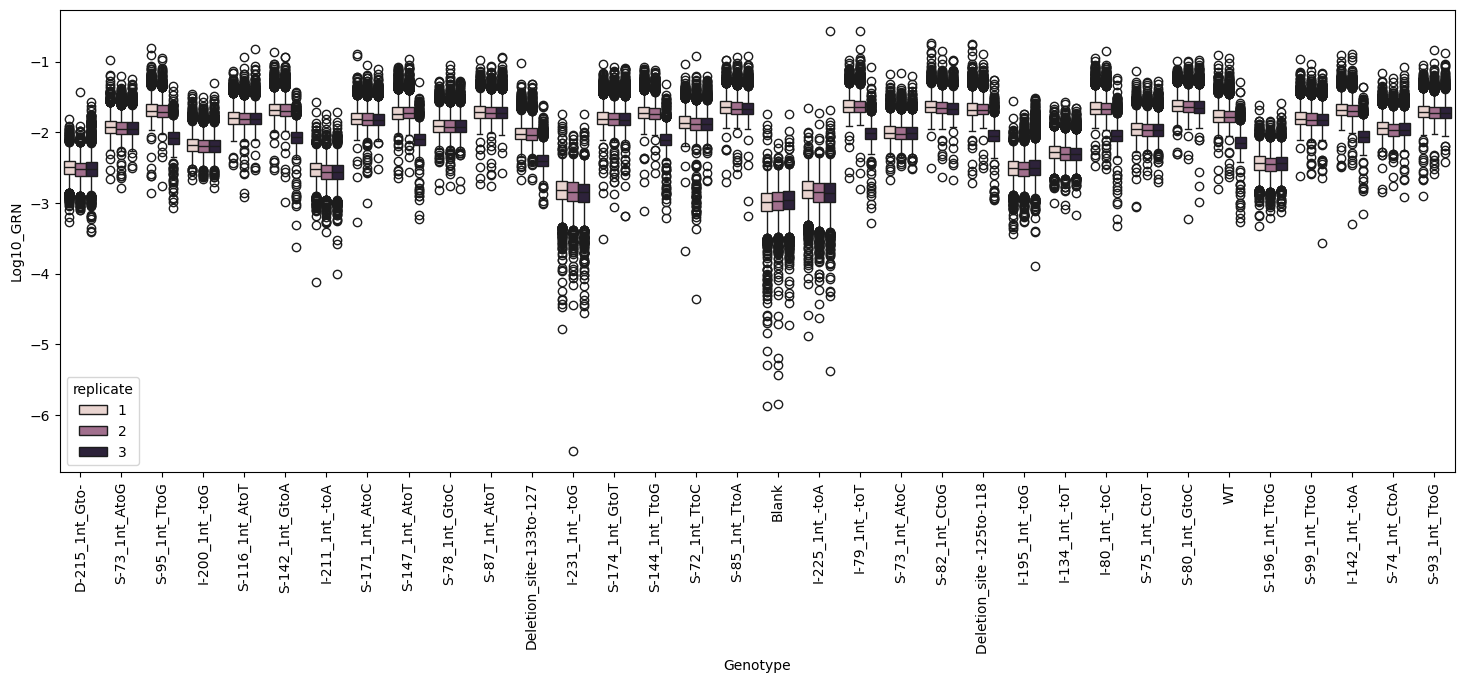

In [22]:
fluo_all = pd.concat([fluo_df_1, fluo_df_2]).reset_index(drop=True)

plt.figure(figsize=(18, 6))
sns.boxplot(data=fluo_all, x='Genotype', y='Log10_GRN', hue='replicate')
plt.gca().tick_params(axis='x', labelrotation=90)

In many cases, replicate 3 is an outlier. These correspond to measurements in plate 2. They might still be usable if normalization relative to the WT is performed separately. However, we do not have any 'blank' measurements from this plate, so it is better to simply drop these replicates.

### Aggregation of plate 1 measurements

In [25]:
# Getting mean and median of normalized fluorescence intensities
fluo_calc_1 = fluo_df_1[['Plate', 'Well', 'mutant_id', 'Genotype', 'T_insertion', 'replicate', 'GRN-B-HLin']].copy()
fluo_calc_1['GRN-B-HLin'] = fluo_calc_1['GRN-B-HLin'] - np.median(fluo_calc_1[fluo_calc_1['Genotype'] == 'Blank']['GRN-B-HLin'])
fluo_agg_1 = fluo_calc_1.groupby(by=['Plate', 'Well', 'mutant_id', 'Genotype', 'T_insertion', 'replicate'], as_index=False).median()
fluo_agg_1 = fluo_agg_1.rename(columns={'GRN-B-HLin': 'Median_norm_GRN'})

fluo_mean_1 = fluo_calc_1.groupby(by=['Plate', 'Well', 'mutant_id', 'Genotype', 'T_insertion', 'replicate'], as_index=False).mean()
fluo_mean_1 = fluo_mean_1.rename(columns={'GRN-B-HLin': 'Mean_norm_GRN'})

fluo_agg_1 = pd.merge(fluo_agg_1, fluo_mean_1, on=['Plate', 'Well', 'mutant_id', 'Genotype', 'T_insertion', 'replicate'])

It seems that using the median or the mean to aggregate measurements within a single well gives quite different results (not so suprising, obviously)

#### Relative expression levels, without aggregating replicates

In [28]:
fluo_agg_1['Relative_median_exp'] = fluo_agg_1['Median_norm_GRN'] / np.median(fluo_agg_1[fluo_agg_1['Genotype'] == 'WT']['Median_norm_GRN'])
fluo_agg_1['Relative_mean_exp'] = fluo_agg_1['Mean_norm_GRN'] / np.median(fluo_agg_1[fluo_agg_1['Genotype'] == 'WT']['Mean_norm_GRN'])

How correlated are they?

<Axes: xlabel='Relative_median_exp', ylabel='Relative_mean_exp'>

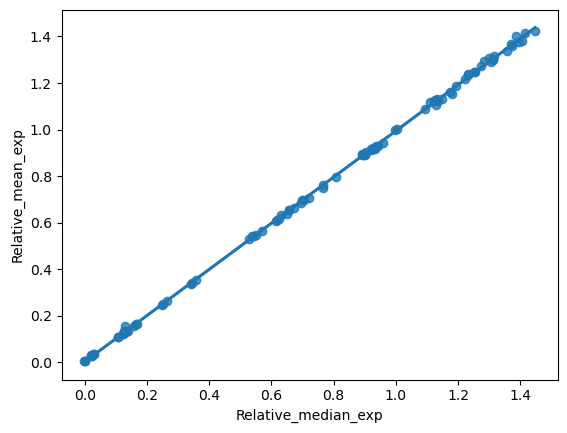

In [30]:
sns.regplot(data=fluo_agg_1, x='Relative_median_exp', y='Relative_mean_exp')

Using one way or the other to define relative expression does not really matter

In [32]:
# Aggregating replicates of the same genotype
# The 'median' definition of relative expression will be used
rel_exp_med = fluo_agg_1[['Genotype', 'T_insertion', 'Median_norm_GRN', 'Relative_median_exp']].groupby(by=['Genotype', 'T_insertion'], as_index=False).median()

rel_exp_max = fluo_agg_1[['Genotype', 'T_insertion', 'Relative_median_exp']].groupby(by=['Genotype', 'T_insertion'], as_index=False).max()
rel_exp_max = rel_exp_max.rename(columns={'Relative_median_exp':'Max_rel_exp'})

rel_exp_min = fluo_agg_1[['Genotype', 'T_insertion', 'Relative_median_exp']].groupby(by=['Genotype', 'T_insertion'], as_index=False).min()
rel_exp_min = rel_exp_min.rename(columns={'Relative_median_exp':'Min_rel_exp'})

rel_exp_med = pd.merge(rel_exp_med, rel_exp_max, on=['Genotype', 'T_insertion'])
rel_exp_med = pd.merge(rel_exp_med, rel_exp_min, on=['Genotype', 'T_insertion'])

#### Relative expression level for each genotype

In [34]:
rel_exp_med = rel_exp_med[rel_exp_med['Genotype'] != 'Blank'].copy().reset_index(drop=True)
rel_exp_med = rel_exp_med.sort_values(by='Relative_median_exp')
order_gen = rel_exp_med['Genotype']

In [237]:
rel_exp_med

,Genotype,T_insertion,Median_norm_GRN,Relative_median_exp,Max_rel_exp,Min_rel_exp
8,I-225_1nt_-toA,False,0.000355,0.022709,0.030886,0.021418
9,I-231_1nt_-toG,False,0.000376,0.024065,0.029050,0.021533
7,I-211_1nt_-toA,False,0.001690,0.108129,0.122768,0.108087
0,D-215_1nt_Gto-,True,0.001958,0.125285,0.138849,0.124163
5,I-195_1nt_-toG,True,0.002045,0.130871,0.134050,0.127702
18,S-196_1nt_TtoG,True,0.002572,0.164599,0.168310,0.156998
3,I-134_1nt_-toT,False,0.003929,0.251447,0.264624,0.249138
6,I-200_1nt_-toG,False,0.005368,0.343527,0.358791,0.342081
2,Deletion_site-133to-127,False,0.008336,0.533458,0.537794,0.529122
20,S-73_1nt_AtoC,True,0.008609,0.550935,0.568130,0.543138


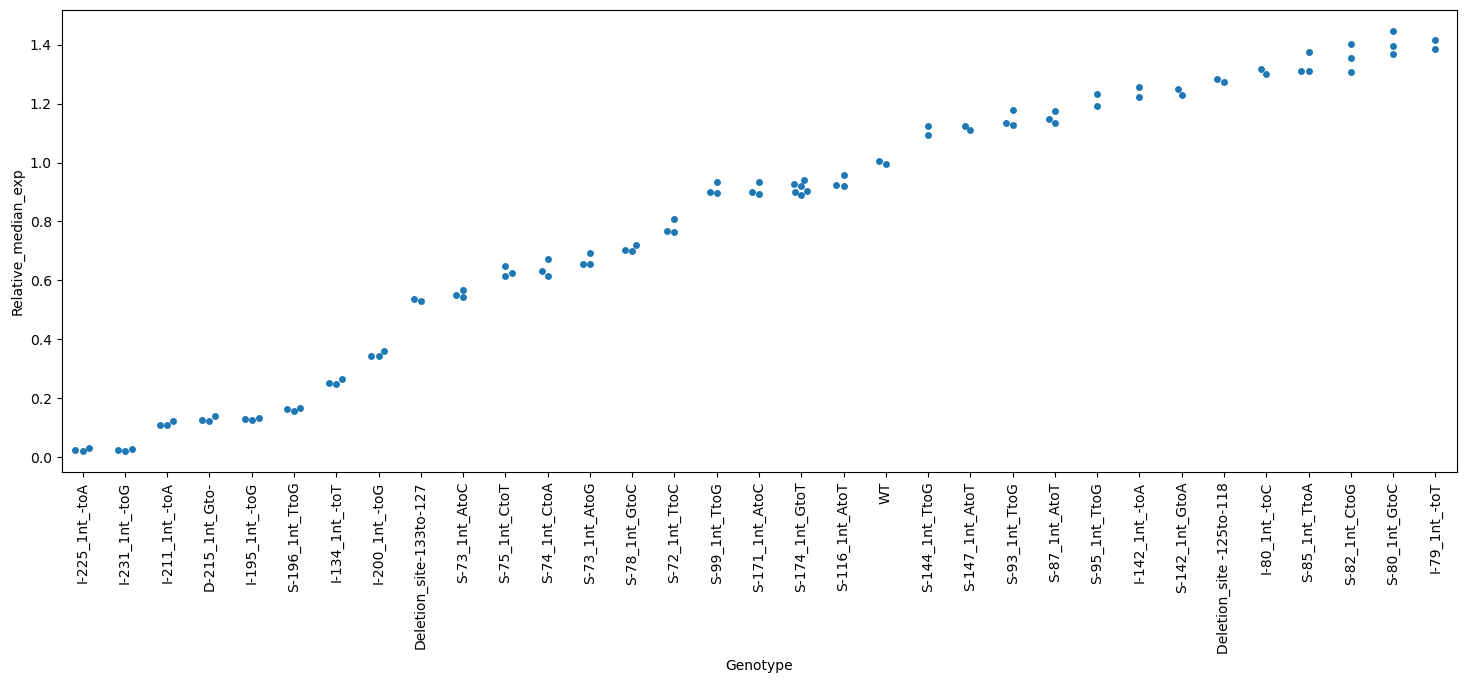

In [35]:
plt.figure(figsize=(18, 6))
sns.swarmplot(data=fluo_agg_1, x='Genotype', y='Relative_median_exp', order=order_gen)
plt.gca().tick_params(axis='x', labelrotation=90)

- site -133 to -127: From 72 to 78 in the genotype numbering
- site -125 to -118: From 80 to 87 in the genotype numbering

Deletion of the whole -133to-127 is barely more impactful than some of the point mutations in the same site

Simlarly, deleting the complete site -125to-118 is less impactful than some point mutations within it

### Aggregation of plate 2 measurements

This set of measurements is not used, because the absence of a non-fluorescent control in the plate prevents proper normalization (this removes replicate 3 for some of the mutants).

## Calibration curve of the SortSeq scores

Now that fluorescence intensities have been converted into relative FCY1 expression, this data can be used to convert SortSeq scores into expression changes!

### Importing the SortSeq data (all scores)

In [44]:
sort_all = pd.read_csv('Supp_data/Sort_scores_all.csv')
sort_NoDead = pd.read_csv('Supp_data/Sort_scores_NoDead.csv')

sort_scores = pd.merge(sort_all, sort_NoDead, suffixes=('_all', '_NoDead'),
                       on=['Mutation type', 'Genotype', 'Position', 'In_F3F4', 'FCY1_position'], how='outer')

In [45]:
# Adding this data to the fluorescence measurements
sort_comp = pd.merge(rel_exp_med, sort_scores, on=['Genotype'], how='left')

In [46]:
sort_comp[sort_comp['Mutation type'].isna()]

,Genotype,T_insertion,Median_norm_GRN,Relative_median_exp,Max_rel_exp,Min_rel_exp,Mutation type,Position,In_F3F4,Median_delta_WT,...,not_zero_p-val_all,n_observed_all,FCY1_position,not_zero_FDR_all,Median_delta_WT_NoDead,Min_delta_WT_NoDead,Max_delta_WT_NoDead,not_zero_p-val_NoDead,n_observed_NoDead,not_zero_FDR_NoDead
8,Deletion_site-133to-127,False,0.008336,0.533458,0.537794,0.529122,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,WT,False,0.015626,1.000000,1.004077,0.995923,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Deletion_site -125to-118,False,0.019969,1.277915,1.281966,1.273863,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Only the expected genotype ids are lost, so NaNs can be removed from the dataframe
sort_comp = sort_comp.dropna(subset='Mutation type').reset_index(drop=True)

### Calibration curve

Text(-1.5, 1.1, 'r = 0.978\np-val = 1.623e-20')

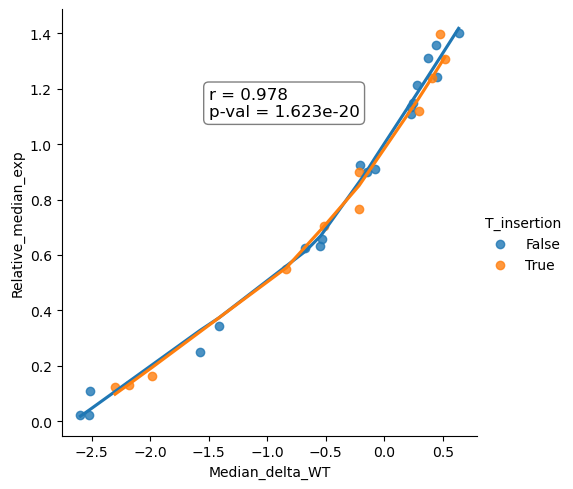

In [49]:
# First, using the 'All' scores
sns.lmplot(data=sort_comp, x='Median_delta_WT', y='Relative_median_exp', hue='T_insertion', lowess=True)

calc_data = sort_comp[['Median_delta_WT', 'Relative_median_exp']].copy().dropna().reset_index(drop=True)
pearson_coeff = stats.pearsonr(calc_data['Median_delta_WT'], calc_data['Relative_median_exp'])
plt.annotate(r"r = "f'{round(pearson_coeff[0], 3)}\np-val = {pearson_coeff[1]:.3e}',
             (-1.5, 1.1), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)

It does not appear linear. There is clearly very high concordance between the SortSeq and the validation mutants!

Text(-1.5, 1.1, 'r = 0.987\np-val = 3.192e-21')

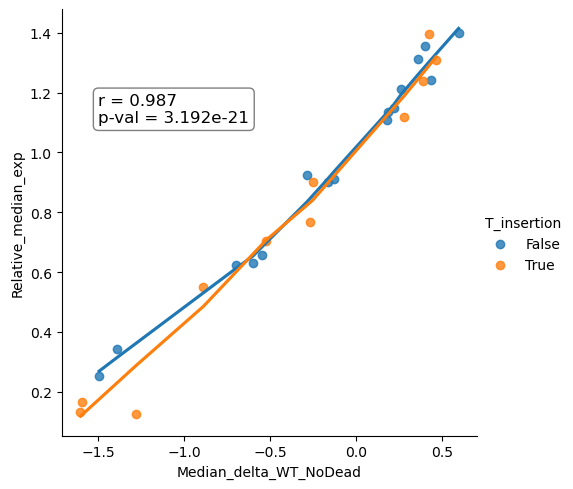

In [51]:
# Second, using the 'NoDead' scores
sns.lmplot(data=sort_comp, x='Median_delta_WT_NoDead', y='Relative_median_exp', hue='T_insertion', lowess=True)

calc_data = sort_comp[['Median_delta_WT_NoDead', 'Relative_median_exp']].copy().dropna().reset_index(drop=True)
pearson_coeff = stats.pearsonr(calc_data['Median_delta_WT_NoDead'], calc_data['Relative_median_exp'])
plt.annotate(r"r = "f'{round(pearson_coeff[0], 3)}\np-val = {pearson_coeff[1]:.3e}',
             (-1.5, 1.1), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)

The curve seems very similar, even though we lose some datapoints (dead mutants which were only seen in the 'dead' bin in SortSeq).

### Converting SortSeq scores into relative expression

To capture the full range of effects, the 'All' SortSeq scores will be used.

Because the relationship appears non linear, SortSeq scores will be converted by fitting a lowess regression on the validation data.

Bootstraping will be implemented in this fitting routine:

- Delta_Ref measurements are sampled (with replacement) for each genotype, and aggregated into medians
- For genotypes included in the validation set, three relative expression measurements are sampled (with replacement) and aggregated into a median
- The lowess model is fit on the sampled validation data and expression changes are inferred for each genotype from the sampled Delta_Refs 

In [58]:
# Importing the complete Delta_Ref measurements ('All' scores after removal of outliers)
sort_all_reps = pd.read_csv("Supp_data/Sort_scores_by_rep_all.csv")

In [62]:
# Setting up a random number generator
rng_boot = np.random.default_rng(677165)

In [58]:
n_iterations = 5000
all_genotypes = list(sort_all_reps['Genotype'].unique())
eval_fit = np.linspace(np.min(sort_comp['Median_delta_WT']), np.max(sort_comp['Median_delta_WT']), 100)

for iter_n in range(n_iterations):
    median_diffs = pd.DataFrame(index=all_genotypes, columns=['Median_delta_WT'])

    # Assembling the dataset of median Delta Ref scores
    for mutant in all_genotypes:
        scores_subset = sort_all_reps[sort_all_reps['Genotype'] == mutant].copy().reset_index(drop=True)
        n_observed = scores_subset.shape[0]
        sampled_diffs = rng_boot.choice(scores_subset['Diff_bin_cell_norm'].values, size=n_observed, replace=True)
        current_median = np.median(sampled_diffs)
        median_diffs.at[mutant, 'Median_delta_WT'] = current_median

    # Assembling a corresponding validation set
    val_genotypes = list(sort_comp['Genotype'].unique())
    val_df = median_diffs.loc[val_genotypes, :].copy()
    val_df['Genotype'] = val_df.index
    val_df['Relative_median_exp'] = pd.Series(dtype='float64')

    for val_mutant in val_genotypes:
        exp_subset = fluo_agg_1[fluo_agg_1['Genotype'] == val_mutant].copy().reset_index(drop=True)
        exp_points = exp_subset.shape[0]
        sampled_exp = rng_boot.choice(exp_subset['Relative_median_exp'].values, size=exp_points, replace=True)
        current_exp = np.median(sampled_exp)
        val_df.at[val_mutant, 'Relative_median_exp'] = current_exp

    # Fitting the lowess and predicting expression levels
    full_x_vals = np.concatenate((median_diffs['Median_delta_WT'].values, eval_fit)).astype('float64')
    pred_res = sm.nonparametric.lowess(exog=val_df['Median_delta_WT'].values, endog=val_df['Relative_median_exp'].values,
                                      xvals=full_x_vals)

    # Separating the predicted expression levels from lin space evalutation
    exp_fcy1 = pred_res[0:len(all_genotypes)].reshape(len(all_genotypes), 1)
    lin_eval = pred_res[len(all_genotypes):].reshape(len(eval_fit), 1)

    # Saving all the results
    if iter_n == 0:
        exp_inferred = exp_fcy1.copy()
        curve_eval = lin_eval.copy()

    else:
        exp_inferred = np.concatenate((exp_inferred, exp_fcy1), axis=1)
        curve_eval = np.concatenate((curve_eval, lin_eval), axis=1)

# Once all iterations have been performed, the appropriate percentiles are extracted
curve_eval_df = pd.DataFrame(columns=['Median_delta_WT', 'Median_rel_exp', 'bot_2_5percent', 'bot_5percent', 'top_95percent', 'top_97_5percent'])
curve_eval_df['Median_delta_WT'] = eval_fit
curve_eval_df['Median_rel_exp'] = np.median(curve_eval, axis=1)
curve_eval_df['bot_2_5percent'] = np.percentile(curve_eval, 2.5, axis=1)
curve_eval_df['bot_5percent'] = np.percentile(curve_eval, 5, axis=1)
curve_eval_df['top_95percent'] = np.percentile(curve_eval, 95, axis=1)
curve_eval_df['top_97_5percent'] = np.percentile(curve_eval, 97.5, axis=1)

exp_predict_df = pd.DataFrame(columns=['Genotype', 'Median_rel_exp', 'bot_2_5percent', 'bot_5percent', 'top_95percent', 'top_97_5percent'])
exp_predict_df['Genotype'] = all_genotypes
exp_predict_df['Median_rel_exp'] = np.median(exp_inferred, axis=1)
exp_predict_df['bot_2_5percent'] = np.percentile(exp_inferred, 2.5, axis=1)
exp_predict_df['bot_5percent'] = np.percentile(exp_inferred, 5, axis=1)
exp_predict_df['top_95percent'] = np.percentile(exp_inferred, 95, axis=1)
exp_predict_df['top_97_5percent'] = np.percentile(exp_inferred, 97.5, axis=1)

In [59]:
# Saving the data
exp_predict_df.to_csv('Supp_data/Rel_exp_fcy1_bootstrap.csv', index=False)
curve_eval_df.to_csv('Supp_data/Calib_lowess_bootstrap.csv', index=False)

In [60]:
sort_comp.to_csv('Supp_data/Sort_valid_comp.csv', index=False)
fluo_agg_1.to_csv('Supp_data/fluo_by_well_validation.csv', index=False)

In [61]:
curve_eval_df.iloc[75:85, :]

,Median_delta_WT,Median_rel_exp,bot_2_5percent,bot_5percent,top_95percent,top_97_5percent
75,-0.147646,0.909239,0.886166,0.889798,0.927020,0.930795
76,-0.115001,0.928891,0.906041,0.909938,0.946821,0.950263
77,-0.082356,0.948922,0.926470,0.930198,0.967109,0.970661
78,-0.049711,0.969600,0.947113,0.951005,0.987495,0.991052
79,-0.017066,0.990390,0.967950,0.972255,1.008220,1.011849
80,0.015579,1.011308,0.989160,0.993521,1.029173,1.032652
81,0.048224,1.032362,1.010647,1.014530,1.050558,1.053981
82,0.080869,1.053450,1.031917,1.035527,1.071793,1.075262
83,0.113514,1.074754,1.052713,1.056104,1.093115,1.096742
84,0.146158,1.095581,1.072490,1.076256,1.114762,1.118626


In [84]:
exp_predict_df = pd.read_csv('Supp_data/Rel_exp_fcy1_bootstrap.csv')
curve_eval_df = pd.read_csv('Supp_data/Calib_lowess_bootstrap.csv')
sort_comp = pd.read_csv('Supp_data/Sort_valid_comp.csv')
fluo_agg_1 = pd.read_csv('Supp_data/fluo_by_well_validation.csv')

We can first plot the fit to the validation data:

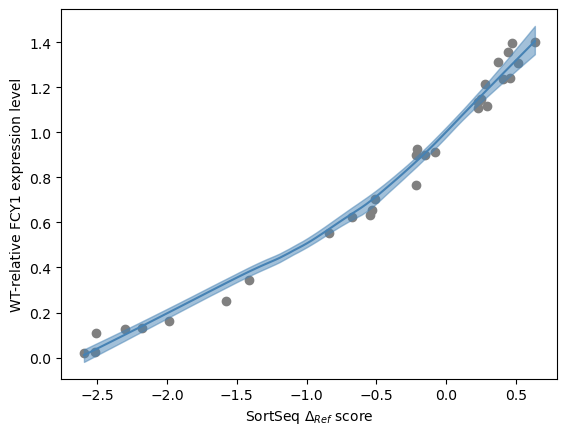

In [87]:
plt.scatter(sort_comp['Median_delta_WT'], sort_comp['Relative_median_exp'], c='grey', zorder=0)
plt.plot(curve_eval_df['Median_delta_WT'], curve_eval_df['Median_rel_exp'], c="steelblue", zorder=2)
plt.fill_between(curve_eval_df['Median_delta_WT'], curve_eval_df['bot_2_5percent'], curve_eval_df['top_97_5percent'], alpha=0.5, color="steelblue", zorder=1)
plt.gca().set_xlabel(r"SortSeq $\Delta_{Ref}$ score")
plt.gca().set_ylabel(r"WT-relative FCY1 expression level")

fit_calib = plt.gcf()
fit_calib.savefig(f"Prelim_figures/Calibration_fit.png", bbox_inches='tight')

In [89]:
np.interp(0, curve_eval_df['Median_delta_WT'], curve_eval_df['bot_2_5percent'])

0.9790382128642019

In [91]:
np.interp(0, curve_eval_df['Median_delta_WT'], curve_eval_df['Median_rel_exp'])

1.0013258136689545

In [93]:
np.interp(0, curve_eval_df['Median_delta_WT'], curve_eval_df['top_97_5percent'])

1.0227246265404928

The fit is good overall, but it might be too conservative.

### Distribution of mutational effects in the F3-F4 region

In [95]:
sort_all_reps.columns

Index(['Lib_code', 'Genotype', 'Mutation type', 'Position', 'In_F3F4',
       'Diff_bin_cell_norm', 'Median_diff_norm', 'Abs_med_diff_norm',
       'MAD_diff_norm', 'n_MAD'],
      dtype='object')

In [97]:
exp_predict_muts = pd.merge(exp_predict_df, sort_all_reps[['Genotype', 'Mutation type', 'Position', 'In_F3F4']].copy().drop_duplicates(),
                            on='Genotype', how='left')
exp_predict_muts['FCY1_position'] = exp_predict_muts['Position'] - 205 + 1*(exp_predict_muts['Mutation type'] == 'Insertion')

exp_predict_F3F4 = exp_predict_muts[exp_predict_muts['In_F3F4']].copy().reset_index(drop=True)

In [99]:
mut_palette = {'Substitution': cm.tab10.colors[9], 
               'Insertion': cm.tab20b.colors[1],
               'Deletion': cm.tab10.colors[3]}

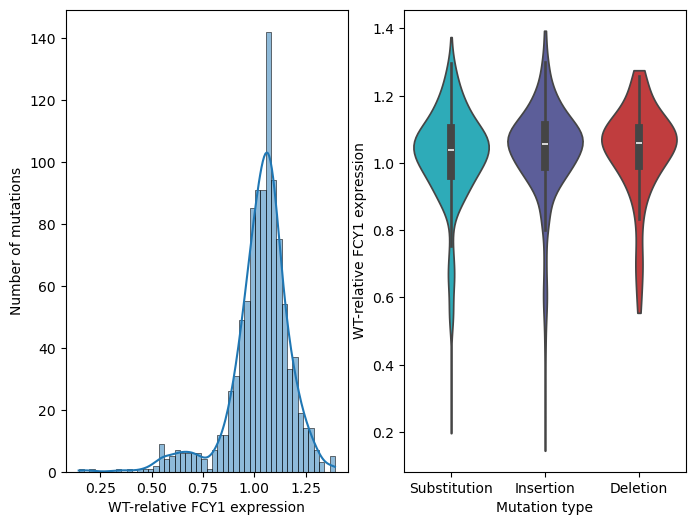

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

sns.histplot(data=exp_predict_F3F4, x='Median_rel_exp', ax=axs[0], kde=True)


sns.violinplot(data=exp_predict_F3F4, x='Mutation type', y='Median_rel_exp', hue='Mutation type',
               palette=mut_palette, order=['Substitution', 'Insertion', 'Deletion'], cut=0, ax=axs[1])

axs[0].set_ylabel('Number of mutations')
axs[0].set_xlabel('WT-relative FCY1 expression')
axs[1].set_ylabel('WT-relative FCY1 expression')

exp_dist = plt.gcf()
exp_dist.savefig(f"Prelim_figures/Dist_effects_expression.png", bbox_inches='tight')

In [103]:
np.quantile(exp_predict_F3F4['Median_rel_exp'], 0.25)

0.976684301920605

In [105]:
np.quantile(exp_predict_F3F4['Median_rel_exp'], 0.75)

1.1093122020523312

In [107]:
exp_predict_F3F4[['Median_rel_exp', 'Mutation type']].groupby(by=['Mutation type'], as_index=False).median()

,Mutation type,Median_rel_exp
0,Deletion,1.059166
1,Insertion,1.056910
2,Substitution,1.037874


In [109]:
exp_predict_F3F4[(exp_predict_F3F4['In_F3F4']) & (exp_predict_F3F4['Median_rel_exp'] < 0.75)].shape

(60, 10)

### Mutational effects by nucleotide position

In [112]:
# Computing median, min and max expression by type and position (grand medians)
exp_pos_calc = exp_predict_F3F4[['Median_rel_exp', 'bot_2_5percent', 'top_97_5percent',
                                 'Mutation type', 'FCY1_position']].copy()

exp_pos_med = exp_pos_calc[['Median_rel_exp', 'Mutation type', 'FCY1_position']].groupby(by=['Mutation type', 'FCY1_position'], as_index=False).median()

exp_pos_min = exp_pos_calc[['bot_2_5percent', 'Mutation type', 'FCY1_position']].groupby(by=['Mutation type', 'FCY1_position'], as_index=False).min()

exp_pos_max = exp_pos_calc[['top_97_5percent', 'Mutation type', 'FCY1_position']].groupby(by=['Mutation type', 'FCY1_position'], as_index=False).max()

exp_pos_med = pd.merge(exp_pos_med, exp_pos_min, on=['Mutation type', 'FCY1_position'], how='outer')
exp_pos_med = pd.merge(exp_pos_med, exp_pos_max, on=['Mutation type', 'FCY1_position'], how='outer')

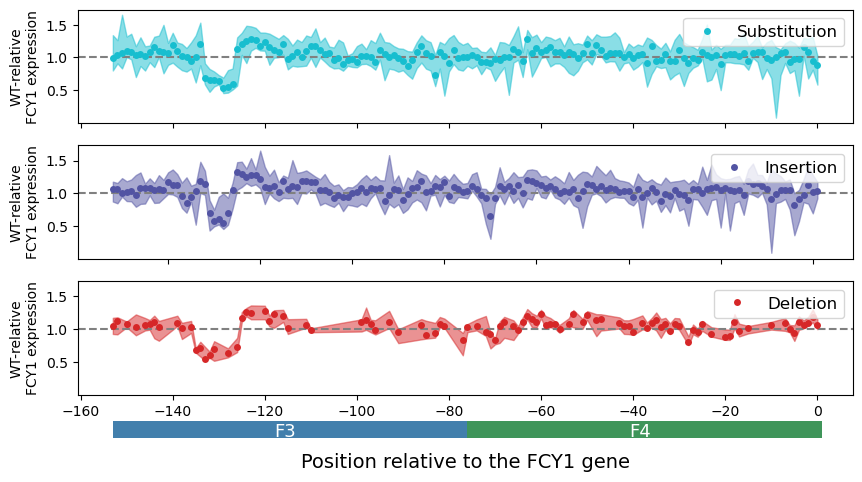

In [114]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharey=True)

axes_list = [axs[0], axs[1], axs[2]]
types_list = ['Substitution', 'Insertion', 'Deletion']

for plot_num in [0, 1, 2]:
    type_to_plot = types_list[plot_num]
    points_subset = exp_pos_med[exp_pos_med['Mutation type'] == type_to_plot].copy().reset_index(drop=True).infer_objects()

    plot_med = sns.stripplot(data=points_subset, x='FCY1_position', y='Median_rel_exp', hue='Mutation type', 
                               ax=axes_list[plot_num], palette=mut_palette, native_scale=True)
    plot_med.legend(fontsize=12, loc='upper right')

    axes_list[plot_num].fill_between(points_subset['FCY1_position'], points_subset['bot_2_5percent'], points_subset['top_97_5percent'],
                                     alpha=0.5, color=mut_palette[type_to_plot], zorder=1)
    axes_list[plot_num].axhline(y=1, c='grey', linestyle='--')

    # y axis label
    axes_list[plot_num].set_ylabel('WT-relative\nFCY1 expression', fontsize=10)

# Adjusting axes labels
axs[0].set_xticklabels([])
axs[0].set_xlabel('')
axs[1].set_xticklabels([])
axs[1].set_xlabel('')
axs[2].set_xlabel('Position relative to the FCY1 gene', fontsize=14, labelpad=25)

# Adding rectangles to identify regions
axs[2].add_patch(Rectangle((-153, -0.4), 77, -0.25, facecolor='#427fac', edgecolor=None, clip_on=False))  # F3
axs[2].annotate("F3", (-115.5, -0.55), annotation_clip=False, color='white', ha='center', va='center', fontsize=13, zorder=1)
axs[2].add_patch(Rectangle((-76, -0.40), 77, -0.25, facecolor='#3f955a', edgecolor=None, clip_on=False))  # F4
axs[2].annotate("F4", (-38.5, -0.55), annotation_clip=False, color='white', ha='center', va='center', fontsize=13, zorder=1)

exp_by_pos = plt.gcf()
exp_by_pos.savefig(f"Prelim_figures/Expression_by_position.png", bbox_inches='tight')

**For the paper**: Maybe this figure, but with points (and corresponding error bars) only for significant hits (1 not included in the confidence interval)

All individual mutational effects, with their confidence intervals:

In [117]:
exp_predict_F3F4['New_nt'] = exp_predict_F3F4['Genotype'].apply(lambda x: x.split('to')[1])

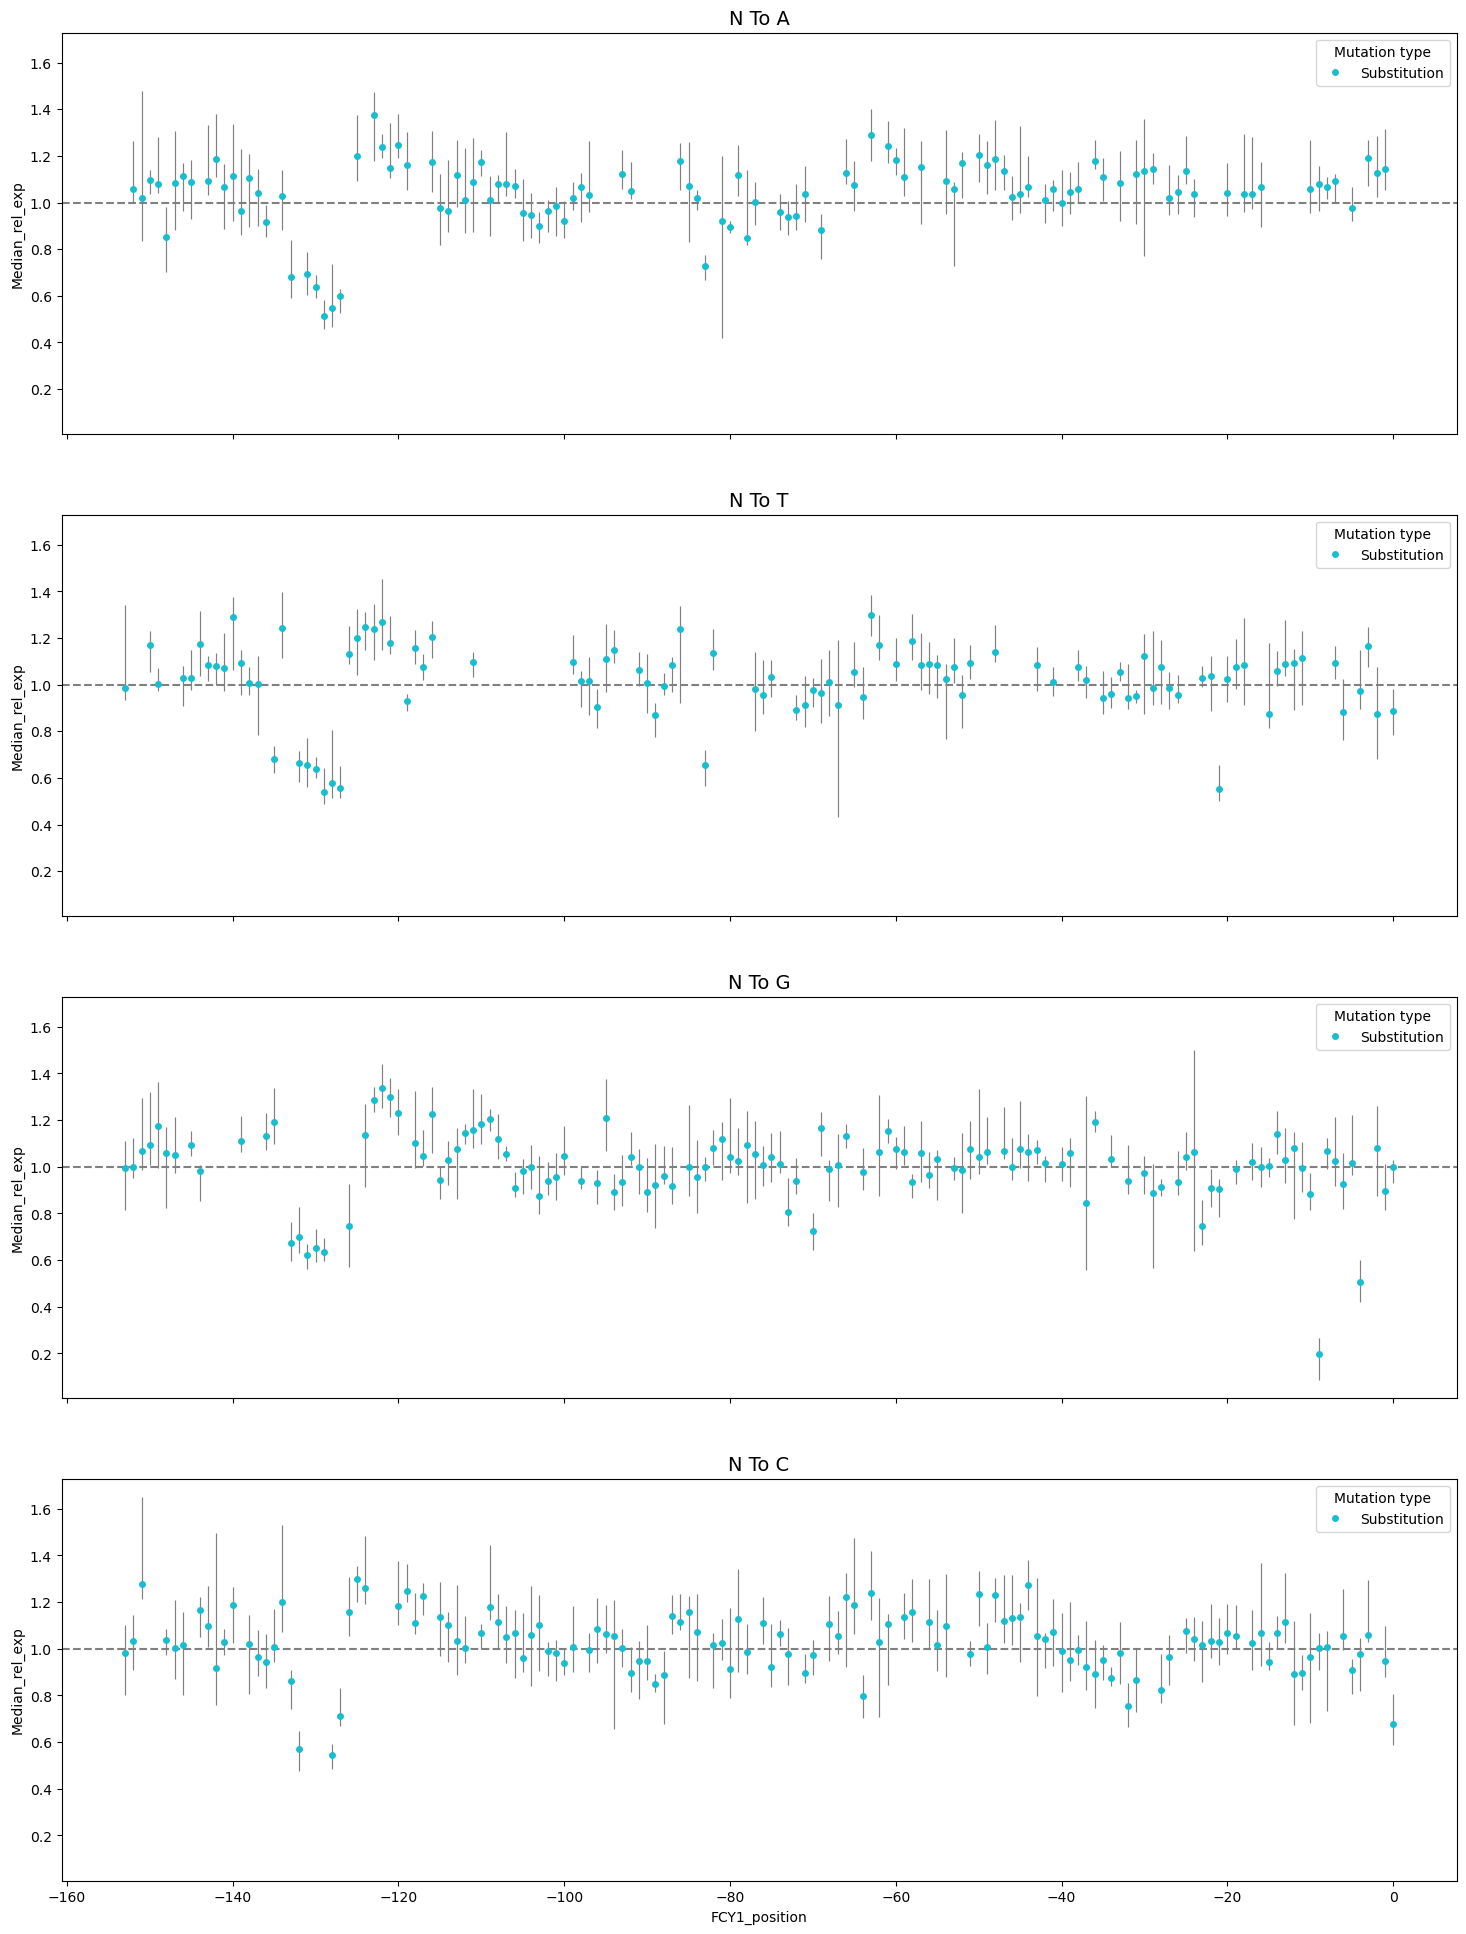

In [118]:
# First figure: Substitutions
# from top to bottom: A, T, G, C

exp_F3F4_sub = exp_predict_F3F4[exp_predict_F3F4['Mutation type'] == 'Substitution'].copy().reset_index(drop=True)

fig, axs = plt.subplots(4, 1, figsize=(18, 24), sharex=True, sharey=True)

toA_sub = exp_F3F4_sub[exp_F3F4_sub['New_nt'] == 'A'].copy().reset_index(drop=True).sort_values(by='FCY1_position')
sns.stripplot(data=toA_sub, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=axs[0], palette=mut_palette, native_scale=True)
a_err = np.array([toA_sub['Median_rel_exp'] - toA_sub['bot_2_5percent'],
                  toA_sub['top_97_5percent'] - toA_sub['Median_rel_exp']])
axs[0].errorbar(toA_sub['FCY1_position'], toA_sub['Median_rel_exp'], yerr=a_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
axs[0].set_title('N To A', fontsize=14)

toT_sub = exp_F3F4_sub[exp_F3F4_sub['New_nt'] == 'T'].copy().reset_index(drop=True).sort_values(by='FCY1_position')
sns.stripplot(data=toT_sub, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=axs[1], palette=mut_palette, native_scale=True)
t_err = np.array([toT_sub['Median_rel_exp'] - toT_sub['bot_2_5percent'],
                  toT_sub['top_97_5percent'] - toT_sub['Median_rel_exp']])
axs[1].errorbar(toT_sub['FCY1_position'], toT_sub['Median_rel_exp'], yerr=t_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
axs[1].set_title('N To T', fontsize=14)

toG_sub = exp_F3F4_sub[exp_F3F4_sub['New_nt'] == 'G'].copy().reset_index(drop=True).sort_values(by='FCY1_position')
sns.stripplot(data=toG_sub, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=axs[2], palette=mut_palette, native_scale=True)
g_err = np.array([toG_sub['Median_rel_exp'] - toG_sub['bot_2_5percent'],
                  toG_sub['top_97_5percent'] - toG_sub['Median_rel_exp']])
axs[2].errorbar(toG_sub['FCY1_position'], toG_sub['Median_rel_exp'], yerr=g_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
axs[2].set_title('N To G', fontsize=14)

toC_sub = exp_F3F4_sub[exp_F3F4_sub['New_nt'] == 'C'].copy().reset_index(drop=True).sort_values(by='FCY1_position')
sns.stripplot(data=toC_sub, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=axs[3], palette=mut_palette, native_scale=True)
c_err = np.array([toC_sub['Median_rel_exp'] - toC_sub['bot_2_5percent'],
                  toC_sub['top_97_5percent'] - toC_sub['Median_rel_exp']])
axs[3].errorbar(toC_sub['FCY1_position'], toC_sub['Median_rel_exp'], yerr=c_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
axs[3].set_title('N To C', fontsize=14)


for k in range(4):
    axs[k].axhline(y=1, linestyle='--', c='grey')

mut_sub = plt.gcf()
mut_sub.savefig(f"Prelim_figures/Substitutions_effects_exp.png", bbox_inches='tight')

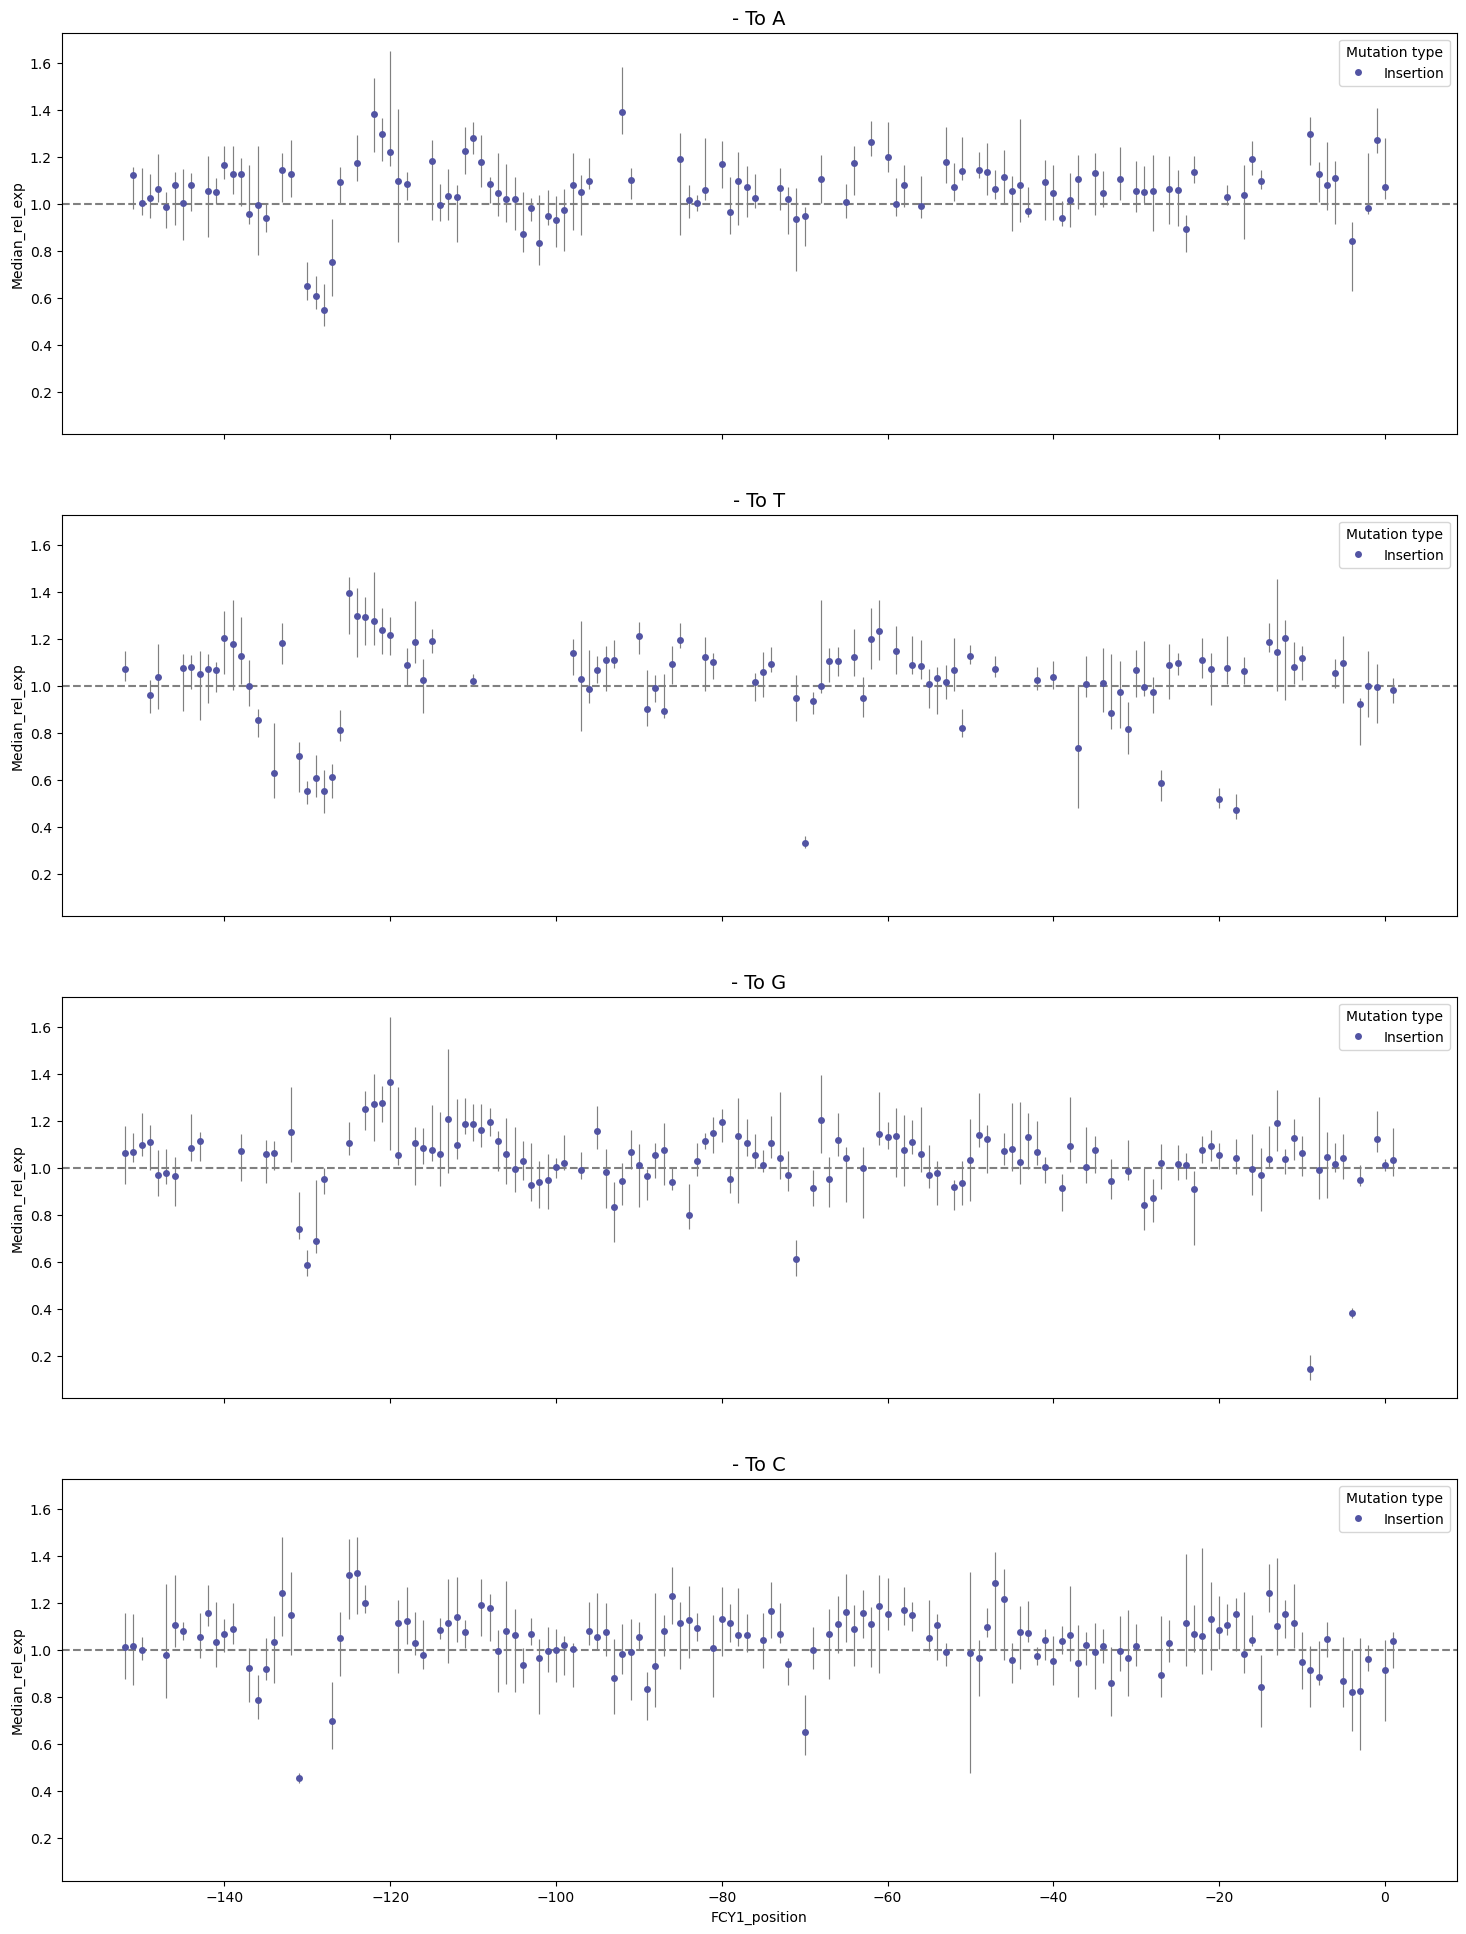

In [119]:
# Second figure: Insertions
# from top to bottom: A, T, G, C

exp_F3F4_ins = exp_predict_F3F4[exp_predict_F3F4['Mutation type'] == 'Insertion'].copy().reset_index(drop=True)

fig, axs = plt.subplots(4, 1, figsize=(18, 24), sharex=True, sharey=True)

toA_sub = exp_F3F4_ins[exp_F3F4_ins['New_nt'] == 'A'].copy().reset_index(drop=True).sort_values(by='FCY1_position')
sns.stripplot(data=toA_sub, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=axs[0], palette=mut_palette, native_scale=True)
a_err = np.array([toA_sub['Median_rel_exp'] - toA_sub['bot_2_5percent'],
                  toA_sub['top_97_5percent'] - toA_sub['Median_rel_exp']])
axs[0].errorbar(toA_sub['FCY1_position'], toA_sub['Median_rel_exp'], yerr=a_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
axs[0].set_title('- To A', fontsize=14)

toT_sub = exp_F3F4_ins[exp_F3F4_ins['New_nt'] == 'T'].copy().reset_index(drop=True).sort_values(by='FCY1_position')
sns.stripplot(data=toT_sub, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=axs[1], palette=mut_palette, native_scale=True)
t_err = np.array([toT_sub['Median_rel_exp'] - toT_sub['bot_2_5percent'],
                  toT_sub['top_97_5percent'] - toT_sub['Median_rel_exp']])
axs[1].errorbar(toT_sub['FCY1_position'], toT_sub['Median_rel_exp'], yerr=t_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
axs[1].set_title('- To T', fontsize=14)

toG_sub = exp_F3F4_ins[exp_F3F4_ins['New_nt'] == 'G'].copy().reset_index(drop=True).sort_values(by='FCY1_position')
sns.stripplot(data=toG_sub, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=axs[2], palette=mut_palette, native_scale=True)
g_err = np.array([toG_sub['Median_rel_exp'] - toG_sub['bot_2_5percent'],
                  toG_sub['top_97_5percent'] - toG_sub['Median_rel_exp']])
axs[2].errorbar(toG_sub['FCY1_position'], toG_sub['Median_rel_exp'], yerr=g_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
axs[2].set_title('- To G', fontsize=14)

toC_sub = exp_F3F4_ins[exp_F3F4_ins['New_nt'] == 'C'].copy().reset_index(drop=True).sort_values(by='FCY1_position')
sns.stripplot(data=toC_sub, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=axs[3], palette=mut_palette, native_scale=True)
c_err = np.array([toC_sub['Median_rel_exp'] - toC_sub['bot_2_5percent'],
                  toC_sub['top_97_5percent'] - toC_sub['Median_rel_exp']])
axs[3].errorbar(toC_sub['FCY1_position'], toC_sub['Median_rel_exp'], yerr=c_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
axs[3].set_title('- To C', fontsize=14)


for k in range(4):
    axs[k].axhline(y=1, linestyle='--', c='grey')

mut_ins = plt.gcf()
mut_ins.savefig(f"Prelim_figures/Insertions_effects_exp.png", bbox_inches='tight')

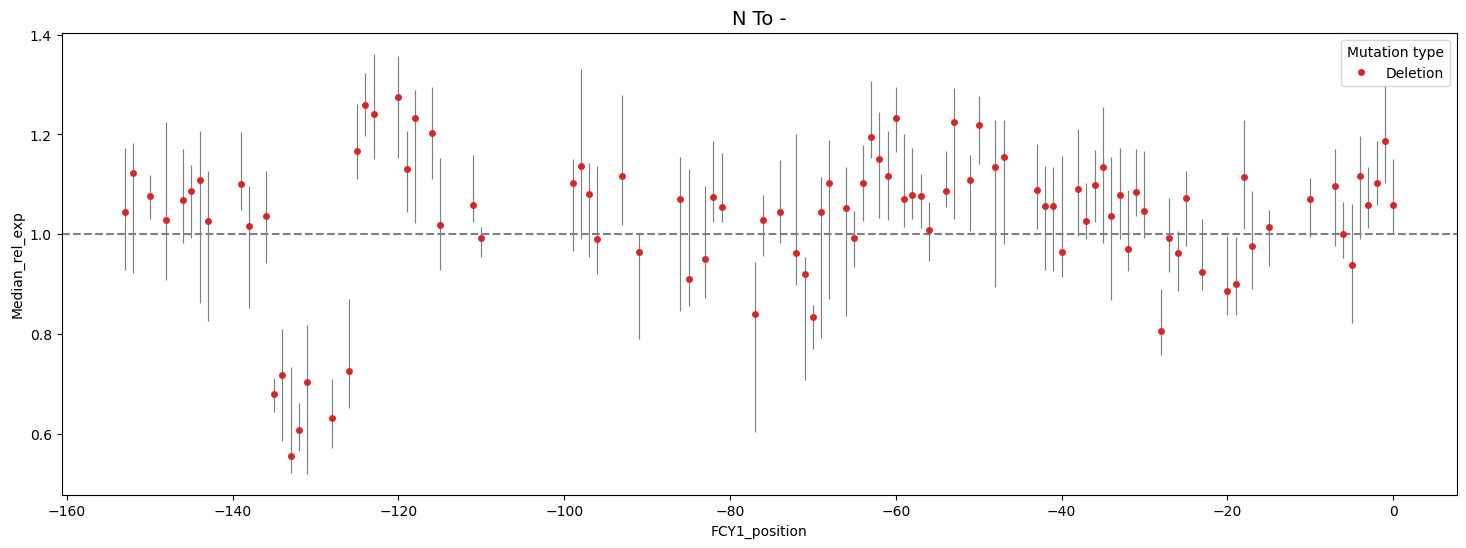

In [120]:
# Third figure: Deletions

exp_F3F4_del = exp_predict_F3F4[exp_predict_F3F4['Mutation type'] == 'Deletion'].copy().reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(18, 6))

sns.stripplot(data=exp_F3F4_del, x='FCY1_position', y='Median_rel_exp',
              hue='Mutation type', ax=ax, palette=mut_palette, native_scale=True)
del_err = np.array([exp_F3F4_del['Median_rel_exp'] - exp_F3F4_del['bot_2_5percent'],
                    exp_F3F4_del['top_97_5percent'] - exp_F3F4_del['Median_rel_exp']])

ax.errorbar(exp_F3F4_del['FCY1_position'], exp_F3F4_del['Median_rel_exp'], yerr=del_err,
                fmt='none', zorder=0, ecolor='grey', linewidth=0.85)
ax.set_title('N To -', fontsize=14)

ax.axhline(y=1, linestyle='--', c='grey')

mut_del = plt.gcf()
mut_del.savefig(f"Prelim_figures/Deletions_effects_exp.png", bbox_inches='tight')

With this new analysis, significant "hits" would be the mutations for which 1 is not part of the confidence interval

In [122]:
hits_upper = exp_predict_F3F4[(exp_predict_F3F4['bot_2_5percent'] > 1) & (exp_predict_F3F4['top_97_5percent'] > 1)].copy().reset_index(drop=True)
hits_lower = exp_predict_F3F4[(exp_predict_F3F4['bot_2_5percent'] < 1) & (exp_predict_F3F4['top_97_5percent'] < 1)].copy().reset_index(drop=True)

hits_95 = pd.concat([hits_lower, hits_upper]).reset_index(drop=True)

In [123]:
hits_95.shape

(439, 11)

According to this definition, we have 410 hits among the 1019 mutations!

### Repeating the calibration using 'NoDead' scores

In [124]:
# Importing the complete Delta_Ref measurements ('NoDead' scores after removal of outliers)
sort_NoDead_reps = pd.read_csv("Supp_data/Sort_scores_by_rep_NoDead.csv")

In [125]:
# Filtering sort_comp to keep only genotypes with NoDead scores
sort_comp_NoDead = sort_comp.dropna(subset=['Median_delta_WT_NoDead']).copy().reset_index(drop=True)

In [88]:
rng_boot = np.random.default_rng(677165)  # Reinitializing the rng, to ensure that the sequence is the same
n_iterations = 5000
all_genotypes = list(sort_NoDead_reps['Genotype'].unique())
eval_fit = np.linspace(np.min(sort_comp_NoDead['Median_delta_WT_NoDead']), np.max(sort_comp_NoDead['Median_delta_WT_NoDead']), 100)

for iter_n in range(n_iterations):
    median_diffs = pd.DataFrame(index=all_genotypes, columns=['Median_delta_WT_NoDead'])

    # Assembling the dataset of median Delta Ref scores
    for mutant in all_genotypes:
        scores_subset = sort_NoDead_reps[sort_NoDead_reps['Genotype'] == mutant].copy().reset_index(drop=True)
        n_observed = scores_subset.shape[0]
        sampled_diffs = rng_boot.choice(scores_subset['Diff_norm_NoDead'].values, size=n_observed, replace=True)
        current_median = np.median(sampled_diffs)
        median_diffs.at[mutant, 'Median_delta_WT_NoDead'] = current_median

    # Assembling a corresponding validation set
    val_genotypes = list(sort_comp_NoDead['Genotype'].unique())
    val_df = median_diffs.loc[val_genotypes, :].copy()
    val_df['Genotype'] = val_df.index
    val_df['Relative_median_exp'] = pd.Series(dtype='float64')

    for val_mutant in val_genotypes:
        exp_subset = fluo_agg_1[fluo_agg_1['Genotype'] == val_mutant].copy().reset_index(drop=True)
        exp_points = exp_subset.shape[0]
        sampled_exp = rng_boot.choice(exp_subset['Relative_median_exp'].values, size=exp_points, replace=True)
        current_exp = np.median(sampled_exp)
        val_df.at[val_mutant, 'Relative_median_exp'] = current_exp

    # Fitting the lowess and predicting expression levels
    full_x_vals = np.concatenate((median_diffs['Median_delta_WT_NoDead'].values, eval_fit)).astype('float64')
    pred_res = sm.nonparametric.lowess(exog=val_df['Median_delta_WT_NoDead'].values, endog=val_df['Relative_median_exp'].values,
                                       xvals=full_x_vals)

    # Separating the predicted expression levels from lin space evalutation
    exp_fcy1 = pred_res[0:len(all_genotypes)].reshape(len(all_genotypes), 1)
    lin_eval = pred_res[len(all_genotypes):].reshape(len(eval_fit), 1)

    # Saving all the results
    if iter_n == 0:
        exp_inferred = exp_fcy1.copy()
        curve_eval = lin_eval.copy()

    else:
        exp_inferred = np.concatenate((exp_inferred, exp_fcy1), axis=1)
        curve_eval = np.concatenate((curve_eval, lin_eval), axis=1)

# Once all iterations have been performed, the appropriate percentiles are extracted
curve_eval_df = pd.DataFrame(columns=['Median_delta_WT_NoDead', 'Median_rel_exp', 'bot_2_5percent', 'bot_5percent', 'top_95percent', 'top_97_5percent'])
curve_eval_df['Median_delta_WT_NoDead'] = eval_fit
curve_eval_df['Median_rel_exp'] = np.median(curve_eval, axis=1)
curve_eval_df['bot_2_5percent'] = np.percentile(curve_eval, 2.5, axis=1)
curve_eval_df['bot_5percent'] = np.percentile(curve_eval, 5, axis=1)
curve_eval_df['top_95percent'] = np.percentile(curve_eval, 95, axis=1)
curve_eval_df['top_97_5percent'] = np.percentile(curve_eval, 97.5, axis=1)

exp_predict_df = pd.DataFrame(columns=['Genotype', 'Median_delta_WT_NoDead', 'bot_2_5percent', 'bot_5percent', 'top_95percent', 'top_97_5percent'])
exp_predict_df['Genotype'] = all_genotypes
exp_predict_df['Median_delta_WT_NoDead'] = np.median(exp_inferred, axis=1)
exp_predict_df['bot_2_5percent'] = np.percentile(exp_inferred, 2.5, axis=1)
exp_predict_df['bot_5percent'] = np.percentile(exp_inferred, 5, axis=1)
exp_predict_df['top_95percent'] = np.percentile(exp_inferred, 95, axis=1)
exp_predict_df['top_97_5percent'] = np.percentile(exp_inferred, 97.5, axis=1)

In [89]:
# Saving the data
exp_predict_df.to_csv('Supp_data/Rel_exp_fcy1_bootstrap_NoDead.csv', index=False)
curve_eval_df.to_csv('Supp_data/Calib_lowess_bootstrap_NoDead.csv', index=False)

**The 'Median_delta_WT_NoDead' column in exp_predict_df above should have been names 'Median_rel_exp'**

### Are the "no Dead" expression estimates consistent with the previous ones?

In [128]:
exp_predict_all = pd.read_csv('Supp_data/Rel_exp_fcy1_bootstrap.csv')
exp_predict_NoDead = pd.read_csv('Supp_data/Rel_exp_fcy1_bootstrap_NoDead.csv')

In [129]:
exp_predict_comp = pd.merge(exp_predict_all, exp_predict_NoDead, on=['Genotype'], how='outer', suffixes=('_all', '_NoDead'))

In [130]:
exp_predict_comp['Position'] = exp_predict_comp['Genotype'].apply(lambda x: int(x.split('_')[0].split('-')[1]))
mut_dict = {'S': 'Sub', 'I': 'Ins', 'D': 'Del'}
exp_predict_comp['Mutation type'] = exp_predict_comp['Genotype'].apply(lambda x: mut_dict[x[0]])

exp_predict_comp['FCY1_position'] = exp_predict_comp['Position'] - 205 + 1*(exp_predict_comp['Mutation type'] == 'Ins')

In [131]:
exp_predict_comp.sort_values(by=['FCY1_position'], ascending=False)

,Genotype,Median_rel_exp,bot_2_5percent_all,bot_5percent_all,top_95percent_all,top_97_5percent_all,Median_delta_WT_NoDead,bot_2_5percent_NoDead,bot_5percent_NoDead,top_95percent_NoDead,top_97_5percent_NoDead,Position,Mutation type,FCY1_position
81,D-242_1nt_Ato-,0.045795,0.005131,0.010120,0.079161,0.084112,NaN,NaN,NaN,NaN,NaN,242,Del,37
449,I-238_1nt_-toC,0.020402,-0.009356,-0.003813,0.041504,0.045310,NaN,NaN,NaN,NaN,NaN,238,Ins,34
935,S-239_1nt_CtoT,0.308814,0.284191,0.288295,0.328175,0.331714,NaN,NaN,NaN,NaN,NaN,239,Sub,34
934,S-236_1nt_GtoC,0.847679,0.819093,0.823382,0.871249,0.875414,0.857610,0.827779,0.832779,0.882695,0.886937,236,Sub,31
448,I-231_1nt_-toG,0.034590,0.005224,0.010739,0.055262,0.059291,NaN,NaN,NaN,NaN,NaN,231,Ins,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,D-12_1nt_Tto-,1.399536,1.342246,1.350415,1.453521,1.466137,1.413559,1.361414,1.369791,1.467896,1.481717,12,Del,-193
630,S-10_1nt_TtoC,0.716267,0.684412,0.689626,0.739158,0.743219,0.681831,0.651603,0.657986,0.705083,0.709296,10,Sub,-195
953,S-4_1nt_GtoA,0.270873,0.250456,0.253554,0.286799,0.289885,NaN,NaN,NaN,NaN,NaN,4,Sub,-201
116,I-0_1nt_-toG,0.997340,0.971784,0.976369,1.016778,1.020564,1.017473,0.992534,0.997010,1.036887,1.040342,0,Ins,-204


There are mutations in the GFP (which we do not care about), because the old version of the file with 'All' sort-seq scores was used. THey will disappear once the bootstrapping routine is rerun with the right input file.

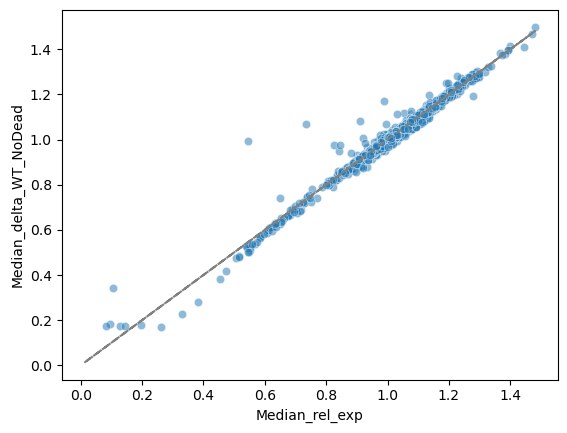

In [133]:
sns.scatterplot(data=exp_predict_comp, x='Median_rel_exp', y='Median_delta_WT_NoDead', alpha=0.5)
plt.plot(exp_predict_comp['Median_rel_exp'], exp_predict_comp['Median_rel_exp'],
        linestyle='--', c='grey')

The estimates are very similar! They only deviate significantly for the lowest expression levels, which makes sense. Some mutants which almost kill expression appear much less severe when the bin with the lowest expression level is removed.

Just to be sure, is the correlation as good when using the min and max of the prediction intervals?

Text(0.5, 1.0, 'Max of interval')

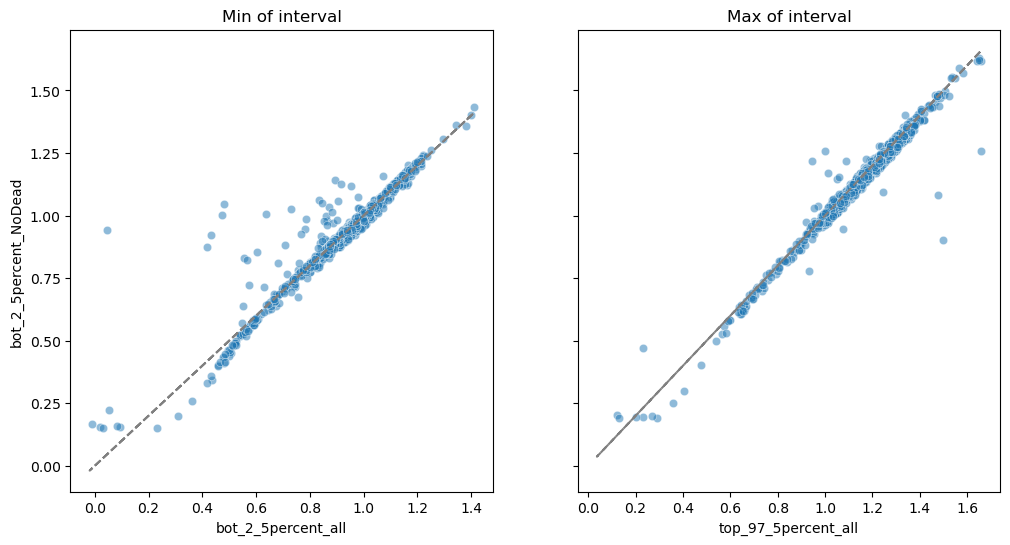

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Left: min values
sns.scatterplot(data=exp_predict_comp, x='bot_2_5percent_all', y='bot_2_5percent_NoDead', alpha=0.5, ax=axs[0])
axs[0].plot(exp_predict_comp['bot_2_5percent_all'], exp_predict_comp['bot_2_5percent_all'], linestyle='--', c='grey')
axs[0].set_title('Min of interval')

# Right: max values
sns.scatterplot(data=exp_predict_comp, x='top_97_5percent_all', y='top_97_5percent_NoDead', alpha=0.5, ax=axs[1])
axs[1].plot(exp_predict_comp['top_97_5percent_all'], exp_predict_comp['top_97_5percent_all'], linestyle='--', c='grey')
axs[1].set_title('Max of interval')

The estimates mostly seem very consistent with each other!

Let's compare the distributions:

<Axes: xlabel='Exp estimate', ylabel='Expression level'>

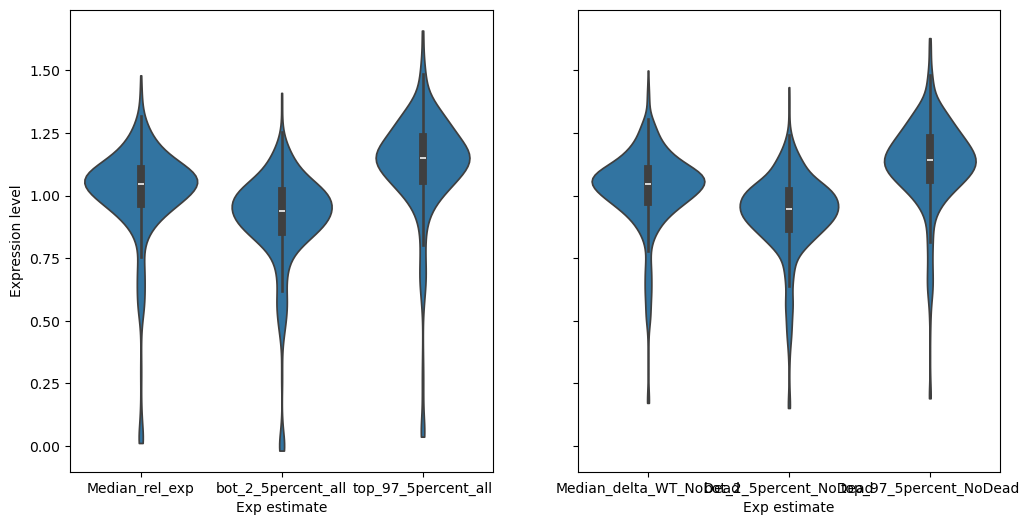

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

all_dist = exp_predict_comp[['Genotype', 'Median_rel_exp', 'bot_2_5percent_all', 'top_97_5percent_all']].copy()
all_dist = pd.melt(all_dist, id_vars=['Genotype'], value_vars=['Median_rel_exp', 'bot_2_5percent_all', 'top_97_5percent_all'],
                   var_name='Exp estimate', value_name='Expression level')
sns.violinplot(data=all_dist, x='Exp estimate', y='Expression level', cut=0, ax=axs[0])

noDead_dist = exp_predict_comp[['Genotype', 'Median_delta_WT_NoDead', 'bot_2_5percent_NoDead', 'top_97_5percent_NoDead']].copy()
noDead_dist = pd.melt(noDead_dist, id_vars=['Genotype'], value_vars=['Median_delta_WT_NoDead', 'bot_2_5percent_NoDead', 'top_97_5percent_NoDead'],
                   var_name='Exp estimate', value_name='Expression level')
sns.violinplot(data=noDead_dist, x='Exp estimate', y='Expression level', cut=0, ax=axs[1])


The median is the same and the distributions have the same shape! Any bias introduced in the sort-seq scores by the 'dead' (0th) bin thus does not translate into the expression level estimates.

## Identifying regions where mutations have significant and consistent effects

Only using the 'All' expression estimates, since we have shown that the choice of score do4es not affect the calibration.

Let's first identify 'blocks' of consecutive positions where the average mutation has a median relative expression at least ±5% from the WT level 

In [162]:
# Aggregating by position
exp_predict_bypos = exp_predict_F3F4.copy().infer_objects().drop(columns=['Genotype', 'Position',
                                                                          'Mutation type', 'In_F3F4', 'New_nt'])
exp_predict_bypos = exp_predict_bypos.groupby(by=['FCY1_position'], as_index=False).mean()

In [166]:
# Identifying blocks where mutations decrease expression
sort_lower_position = exp_predict_bypos[exp_predict_bypos['top_97_5percent'] < 1.0]
sort_lower_position = sort_lower_position.sort_values(by='FCY1_position').copy().reset_index(drop=True)

lower_blocks = []
current_list = []

for row in range(sort_lower_position.shape[0]):
    current_pos = sort_lower_position.at[row, 'FCY1_position']
    if row+1 < sort_lower_position.shape[0]:
        next_pos = sort_lower_position.at[row+1, 'FCY1_position']
        current_list += [current_pos]

        if (int(next_pos) - int(current_pos)) != 1:
            lower_blocks += [current_list,]
            current_list = []

    else:
        current_list += [current_pos]
        lower_blocks += [current_list,]

lower_blocks

[[-132.0, -131.0, -130.0, -129.0, -128.0, -127.0],
 [-89.0],
 [-83.0],
 [-71.0, -70.0],
 [-9.0],
 [-4.0]]

In [168]:
# Identifying blocks where mutations increase expression
sort_higher_position = exp_predict_bypos[exp_predict_bypos['bot_2_5percent'] > 1.0]
sort_higher_position = sort_higher_position.sort_values(by='FCY1_position').copy().reset_index(drop=True)

higher_blocks = []
current_list = []

for row in range(sort_higher_position.shape[0]):
    current_pos = sort_higher_position.at[row, 'FCY1_position']
    if row+1 < sort_higher_position.shape[0]:
        next_pos = sort_higher_position.at[row+1, 'FCY1_position']
        current_list += [current_pos]

        if (int(next_pos) - int(current_pos)) != 1:
            higher_blocks += [current_list,]
            current_list = []

    else:
        current_list += [current_pos]
        higher_blocks += [current_list,]

higher_blocks

[[-150.0],
 [-140.0],
 [-125.0, -124.0, -123.0, -122.0, -121.0, -120.0],
 [-118.0, -117.0, -116.0],
 [-111.0, -110.0, -109.0, -108.0],
 [-95.0],
 [-74.0],
 [-63.0],
 [-61.0, -60.0, -59.0, -58.0, -57.0],
 [-48.0, -47.0],
 [-14.0, -13.0]]

Assessing mean expression level and fraction of significant mutations (according to CI) within each block

In [170]:
prom_block = pd.DataFrame(columns=['Block', 'Positions', 'Mean_rel_exp', 'n_mutations', 'n_significant', 'frac_significant'])
low_blocks = [f'{x[0]} to {x[-1]}' for x in lower_blocks]
high_blocks = [f'{x[0]} to {x[-1]}' for x in higher_blocks]

prom_higher = prom_block.copy()
prom_higher['Positions'] = higher_blocks
prom_higher['Block'] = high_blocks

prom_lower = prom_block.copy()
prom_lower['Positions'] = lower_blocks
prom_lower['Block'] = low_blocks

In [172]:
# Filling the prom_higher df
for row in range(prom_higher.shape[0]):
    list_block = prom_higher.at[row, 'Positions']
    exp_subset = exp_predict_F3F4[exp_predict_F3F4['FCY1_position'].isin(list_block)].copy().reset_index(drop=True)

    prom_higher.at[row, 'Mean_rel_exp'] = np.mean(exp_subset['Median_rel_exp'])
    prom_higher.at[row, 'n_mutations'] = exp_subset.shape[0]
    prom_higher.at[row, 'n_significant'] = np.sum(exp_subset['bot_2_5percent'] > 1.05)

prom_higher['frac_significant'] = prom_higher['n_significant'] / prom_higher['n_mutations']

In [174]:
prom_higher

,Block,Positions,Mean_rel_exp,n_mutations,n_significant,frac_significant
0,-150.0 to -150.0,[-150.0],1.076715,7,2,0.285714
1,-140.0 to -140.0,[-140.0],1.170886,6,2,0.333333
2,-125.0 to -120.0,"[-125.0, -124.0, -123.0, -122.0, -121.0, -120.0]",1.255178,40,38,0.95
3,-118.0 to -116.0,"[-118.0, -117.0, -116.0]",1.123347,20,7,0.35
4,-111.0 to -108.0,"[-111.0, -110.0, -109.0, -108.0]",1.134208,26,13,0.5
5,-95.0 to -95.0,[-95.0],1.110762,6,2,0.333333
6,-74.0 to -74.0,[-74.0],1.063204,7,2,0.285714
7,-63.0 to -63.0,[-63.0],1.160929,7,5,0.714286
8,-61.0 to -57.0,"[-61.0, -60.0, -59.0, -58.0, -57.0]",1.122909,35,14,0.4
9,-48.0 to -47.0,"[-48.0, -47.0]",1.13909,14,5,0.357143


In [176]:
# Filling the prom_lower df
for row in range(prom_lower.shape[0]):
    list_block = prom_lower.at[row, 'Positions']
    exp_subset = exp_predict_F3F4[exp_predict_F3F4['FCY1_position'].isin(list_block)].copy().reset_index(drop=True)

    prom_lower.at[row, 'Mean_rel_exp'] = np.mean(exp_subset['Median_rel_exp'])
    prom_lower.at[row, 'n_mutations'] = exp_subset.shape[0]
    prom_lower.at[row, 'n_significant'] = np.sum(exp_subset['top_97_5percent'] < 0.95)

prom_lower['frac_significant'] = prom_lower['n_significant'] / prom_lower['n_mutations']

In [178]:
prom_lower

,Block,Positions,Mean_rel_exp,n_mutations,n_significant,frac_significant
0,-132.0 to -127.0,"[-132.0, -131.0, -130.0, -129.0, -128.0, -127.0]",0.669532,39,35,0.897436
1,-89.0 to -89.0,[-89.0],0.889922,6,3,0.5
2,-83.0 to -83.0,[-83.0],0.922013,7,2,0.285714
3,-71.0 to -70.0,"[-71.0, -70.0]",0.835508,14,5,0.357143
4,-9.0 to -9.0,[-9.0],0.773397,6,2,0.333333
5,-4.0 to -4.0,[-4.0],0.802975,7,3,0.428571


#### Similarly, what fraction of variants have significant effects within the AT-rich region?

In [181]:
AT_position = list(range(-118, -72))

AT_subset = exp_predict_F3F4[exp_predict_F3F4['FCY1_position'].isin(AT_position)].copy().reset_index(drop=True)
total_AT = AT_subset.shape[0] 
significant_AT = np.sum((AT_subset['bot_2_5percent'] > 1.05) + (AT_subset['top_97_5percent'] < 0.95))
frac_AT = significant_AT / total_AT

In [183]:
print(f'{frac_AT*100}% in poly A/T ({significant_AT}/{total_AT})')

17.627118644067796% in poly A/T (52/295)


In [185]:
out_AT = exp_predict_F3F4[~exp_predict_F3F4['FCY1_position'].isin(AT_position)].copy().reset_index(drop=True)
total_out = out_AT.shape[0] 
significant_out = np.sum((out_AT['bot_2_5percent'] > 1.05) + (out_AT['top_97_5percent'] < 0.95))
frac_out = significant_out / total_out

print(f'{frac_out*100}% outside poly A/T ({significant_out}/{total_out})')

26.65745856353591% outside poly A/T (193/724)


In [187]:
np.sort(out_AT['FCY1_position'].unique())

array([-153., -152., -151., -150., -149., -148., -147., -146., -145.,
       -144., -143., -142., -141., -140., -139., -138., -137., -136.,
       -135., -134., -133., -132., -131., -130., -129., -128., -127.,
       -126., -125., -124., -123., -122., -121., -120., -119.,  -72.,
        -71.,  -70.,  -69.,  -68.,  -67.,  -66.,  -65.,  -64.,  -63.,
        -62.,  -61.,  -60.,  -59.,  -58.,  -57.,  -56.,  -55.,  -54.,
        -53.,  -52.,  -51.,  -50.,  -49.,  -48.,  -47.,  -46.,  -45.,
        -44.,  -43.,  -42.,  -41.,  -40.,  -39.,  -38.,  -37.,  -36.,
        -35.,  -34.,  -33.,  -32.,  -31.,  -30.,  -29.,  -28.,  -27.,
        -26.,  -25.,  -24.,  -23.,  -22.,  -21.,  -20.,  -19.,  -18.,
        -17.,  -16.,  -15.,  -14.,  -13.,  -12.,  -11.,  -10.,   -9.,
         -8.,   -7.,   -6.,   -5.,   -4.,   -3.,   -2.,   -1.,    0.,
          1.])

## Preparing supp figures related to sort-seq

### S16 Fig: More detailed look at the validation

In [189]:
exp_predict_comp[exp_predict_comp['Genotype'] == 'I-94_1nt_-toT']

,Genotype,Median_rel_exp,bot_2_5percent_all,bot_5percent_all,top_95percent_all,top_97_5percent_all,Median_delta_WT_NoDead,bot_2_5percent_NoDead,bot_5percent_NoDead,top_95percent_NoDead,top_97_5percent_NoDead,Position,Mutation type,FCY1_position
584,I-94_1nt_-toT,1.021841,0.997023,1.001216,1.044736,1.049486,1.036879,1.013778,1.017749,1.055839,1.059645,94,Ins,-110


In [191]:
# Preparing arrays of difference for error bars
fit_exp_err = np.array([sort_comp['Relative_median_exp'] - sort_comp['Min_rel_exp'],
                        sort_comp['Max_rel_exp'] - sort_comp['Relative_median_exp']])
fit_scores_err = np.array([sort_comp['Median_delta_WT'] - sort_comp['Min_delta_WT'],
                           sort_comp['Max_delta_WT'] - sort_comp['Median_delta_WT']])

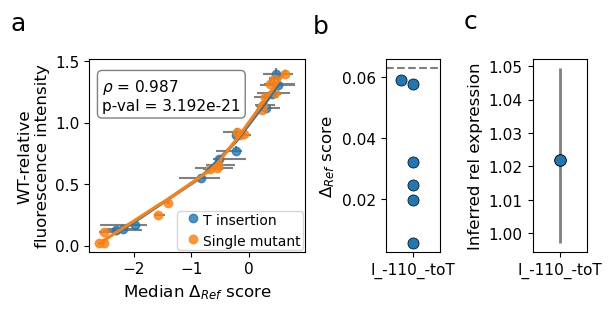

In [193]:
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11

fig, axs = plt.subplots(1, 3, figsize=(6, 3), gridspec_kw={'width_ratios': [4, 1, 1]}, constrained_layout=True)

# Panel A
sns.regplot(data=sort_comp[sort_comp['T_insertion'] == True], x='Median_delta_WT', y='Relative_median_exp', lowess=True,
            ax=axs[0], label='T insertion')
sns.regplot(data=sort_comp[sort_comp['T_insertion'] == False], x='Median_delta_WT', y='Relative_median_exp', lowess=True,
            ax=axs[0], label='Single mutant')
axs[0].errorbar(sort_comp['Median_delta_WT'], sort_comp['Relative_median_exp'], xerr=fit_scores_err, yerr=fit_exp_err,
                fmt='none', zorder=0, ecolor='grey')
axs[0].legend(loc='lower right', handletextpad=-0.25, borderaxespad=0.15, borderpad=0.15, scatteryoffsets=[0.65])

calc_data = sort_comp[['Median_delta_WT', 'Relative_median_exp']].copy().dropna().reset_index(drop=True)
rho_coeff = stats.spearmanr(calc_data['Median_delta_WT'], calc_data['Relative_median_exp'])
axs[0].annotate(r"$\rho$ = "f'{round(pearson_coeff[0], 3)}\np-val = {pearson_coeff[1]:.3e}',
                (-2.55, 1.1), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=11)
axs[0].set_ylabel('WT-relative\nfluorescence intensity')
axs[0].set_xlabel(r"Median $\Delta_{Ref}$ score")

# Panel B
sns.swarmplot(data=sort_all_reps[sort_all_reps['Genotype'] == 'I-94_1nt_-toT'], x='Position', y='Diff_bin_cell_norm',
              ax=axs[1], s=8, edgecolor='black', linewidth=0.5)
axs[1].axhline(y=np.median(sort_all_reps['Diff_bin_cell_norm']), linestyle='--', color='grey')
axs[1].set_xticks(['94.0'], labels=['I_-110_-toT'])
axs[1].set_ylabel(r"$\Delta_{Ref}$ score")
axs[1].set_xlabel('')

# Panel C
pred_subset = exp_predict_comp[exp_predict_comp['Genotype'] == 'I-94_1nt_-toT'].copy().reset_index(drop=True)
err_bar = np.array([pred_subset['Median_rel_exp'] - pred_subset['bot_2_5percent_all'],
                    pred_subset['top_97_5percent_all'] - pred_subset['Median_rel_exp']])
sns.scatterplot(data=pred_subset, x='FCY1_position', y='Median_rel_exp', ax=axs[2], s=70, edgecolor='black')
axs[2].errorbar(pred_subset['FCY1_position'], pred_subset['Median_rel_exp'], yerr=err_bar,
                fmt='none', zorder=0, ecolor='grey', linewidth=2)
axs[2].set_xticks([-110], labels=['I_-110_-toT'])
axs[2].set_ylabel(r"Inferred rel expression")
axs[2].set_xlabel('')

# Identifying the panels
axs[0].annotate('a', (-4.15, 1.75), fontsize=18, annotation_clip=False)
axs[1].annotate('b', (-1.85, 0.0745), fontsize=18, annotation_clip=False)
axs[2].annotate('c', (-131.5, 1.0613), fontsize=18, annotation_clip=False)

FigS16 = plt.gcf()
FigS16.savefig('Supp_figs/S16Fig.tiff', bbox_inches='tight', dpi=600)

### S15 Fig: Indels enriched in competition vs sort-seq

#### Importing the final 300 paired-end selection coefficients

In [197]:
s_300_final = pd.read_csv("Supp_data/s_300_5FC_no_out.csv")

# Selecting Indels in FCY1, after removing the biased replicates
s_300_indels = s_300_final[s_300_final['To_ignore'] == False].copy().reset_index(drop=True)
s_300_indels = s_300_indels[s_300_indels['FCY1_position'] > 0].copy().reset_index(drop=True)
s_300_indels = s_300_indels[(s_300_indels['Mutation type'] == 'Insertion') | (s_300_indels['Mutation type'] == 'Deletion')].copy().reset_index(drop=True)

Indels which are neutral were detected at the very end (last base) of the sequenced region. These may represent sequencing errors and are dropped.

In [200]:
s_300_indels = s_300_indels[s_300_indels['FCY1_position'] < 128].copy().reset_index(drop=True)

In [202]:
# Keeping only the med, min and max values
s_300_indels = s_300_indels[['Genotype', 'Mutation type', 'FCY1_position',
                            'Median_s_ignored', 'Min_s_ignored', 'Max_s_ignored']].copy().drop_duplicates()

# Renaming the mutation types
mut_rename = {'Substitution': 'Sub', 'Insertion': 'Ins', 'Deletion': 'Del'}
s_300_indels['Mutation type'] = s_300_indels['Mutation type'].apply(lambda x: mut_rename[x])

#### Similarly preparing a df for the sort-seq scores

In [205]:
# Using sort_scores defined above
sort_indels = sort_scores[(sort_scores['FCY1_position'] > 0) & (sort_scores['FCY1_position'] < 43)].copy().reset_index(drop=True)
sort_indels = sort_indels[(sort_indels['Mutation type']=='Insertion') | (sort_indels['Mutation type'] == 'Deletion')].copy().reset_index(drop=True)
sort_indels['Mutation type'] = sort_indels['Mutation type'].apply(lambda x: mut_rename[x])

#### Preparing data for the comparison between indels before and after the second methionine

In [208]:
indels_comp = sort_comp[sort_comp['In_F3F4'] == False].copy().reset_index(drop=True)
indels_comp = indels_comp[['Genotype', 'T_insertion', 'Median_norm_GRN', 'Relative_median_exp',
                           'Max_rel_exp', 'Min_rel_exp', 'Mutation type', 'Position', 'In_F3F4']].copy()
indels_comp = indels_comp.rename(columns={'Relative_median_exp': 'Median_rel_cyto',
                                          'Max_rel_exp': 'Max_rel_cyto', 'Min_rel_exp': 'Min_rel_cyto'})
mut_long_dict = {'Substitution': 'Sub', 'Insertion': 'Ins', 'Deletion': 'Del'}
indels_comp['Mutation type'] = indels_comp['Mutation type'].apply(lambda x: mut_long_dict[x])

indels_comp = pd.merge(indels_comp, exp_predict_comp, on=['Genotype', 'Position', 'Mutation type'], how='left')
indels_comp['Second_Met'] = indels_comp['FCY1_position'] >= 16
indels_comp['Second_Met'] = indels_comp['Second_Met'].apply(lambda x: 'After' if x else 'Before')

# Preparing a df to plot cytometry and sort-seq expression as two x vals
indels_cyto = indels_comp[['Genotype', 'T_insertion', 'Median_rel_cyto', 'Max_rel_cyto',
                           'Min_rel_cyto', 'Mutation type', 'Position', 'In_F3F4', 'Second_Met']].copy()
indels_cyto['x_pos'] = 1
indels_cyto['x_pos'] += -0.1 * 1*(indels_cyto['Second_Met'] == 'Before')
indels_cyto['x_pos'] += 0.1 * 1*(indels_cyto['Second_Met'] == 'After')
indels_cyto = indels_cyto.rename(columns={'Median_rel_cyto': 'Median_rel_exp', 
                                          'Max_rel_cyto': 'Max_rel_exp',
                                          'Min_rel_cyto': 'Min_rel_exp'})
indels_cyto['Data_type'] = 'Cytometry'

indels_sort = indels_comp[['Genotype', 'T_insertion', 'Median_rel_exp', 'bot_2_5percent_all',
                           'top_97_5percent_all', 'Mutation type', 'Position', 'In_F3F4', 'Second_Met']].copy()
indels_sort['x_pos'] = 2
indels_sort['x_pos'] += -0.1 * 1*(indels_sort['Second_Met'] == 'Before')
indels_sort['x_pos'] += 0.1 * 1*(indels_sort['Second_Met'] == 'After')
indels_sort = indels_sort.rename(columns={'top_97_5percent_all': 'Max_rel_exp',
                                          'bot_2_5percent_all': 'Min_rel_exp'})
indels_sort['Data_type'] = 'Sort-seq'

indels_valid = pd.concat([indels_cyto, indels_sort]).reset_index(drop=True)
indels_valid['x_pos'] += np.random.normal(0, 0.025, size=indels_valid.shape[0])

<Axes: xlabel='x_pos', ylabel='Median_rel_exp'>

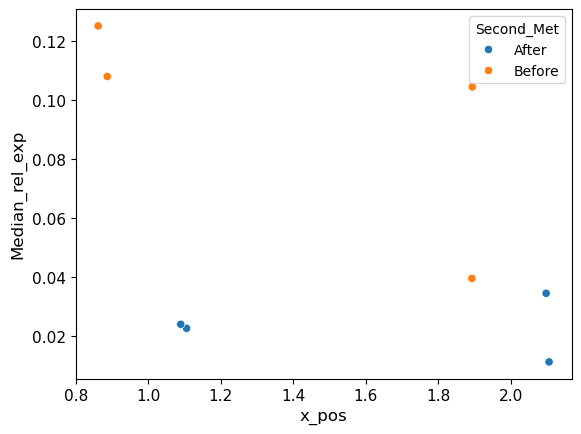

In [210]:
sns.scatterplot(data=indels_valid, x='x_pos', y='Median_rel_exp', hue='Second_Met')

In [212]:
# For all rel exp estimates
exp_predict_indels = exp_predict_comp[(exp_predict_comp['FCY1_position'] > 0) & (exp_predict_comp['FCY1_position'] < 43)].copy().reset_index(drop=True)
exp_predict_indels = exp_predict_indels[exp_predict_indels['Mutation type'] != 'Sub'].copy().reset_index(drop=True)
exp_predict_indels['Second_Met'] = exp_predict_indels['FCY1_position'] >= 16
exp_predict_indels['Second_Met'] = exp_predict_indels['Second_Met'].apply(lambda x: 'After' if x else 'Before')

# Insertions at position 1 are removed, because they are before the intact ATG
exp_predict_indels = exp_predict_indels[exp_predict_indels['FCY1_position'] > 1].copy().reset_index(drop=True)

<Axes: xlabel='Second_Met', ylabel='Median_rel_exp'>

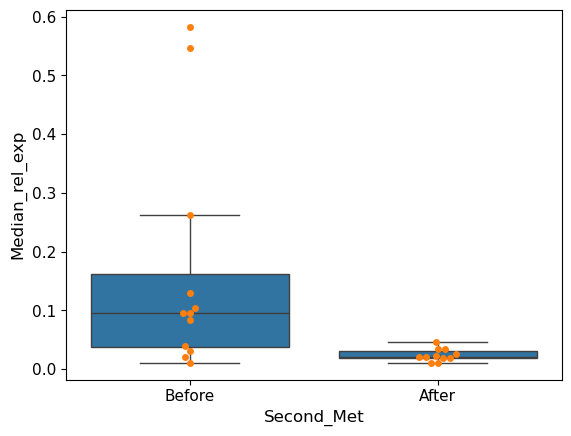

In [214]:
sns.boxplot(data=exp_predict_indels, x='Second_Met', y='Median_rel_exp', fliersize=0)
sns.swarmplot(data=exp_predict_indels, x='Second_Met', y='Median_rel_exp')

#### Making the figure

In [217]:
mut_palette = {'Sub': cm.tab10.colors[9], 
               'Ins': cm.tab20b.colors[1],
               'Del': cm.tab10.colors[3]}

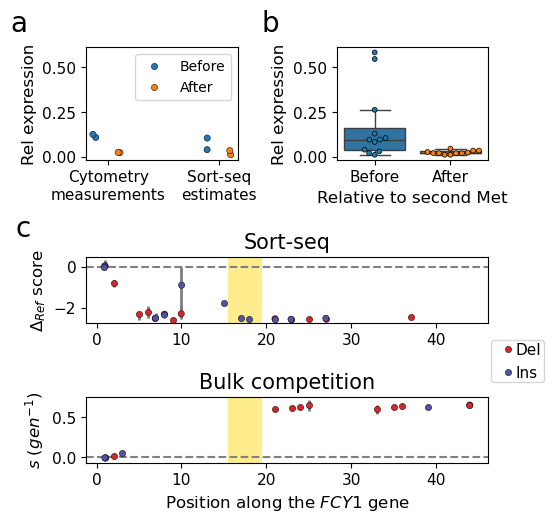

In [234]:
# Preparing the figure
fig = plt.figure(figsize=(6, 6))

grid = gridspec.GridSpec(ncols=15, nrows=20, figure=fig)
#ax1 = fig.add_subplot(grid[0:3, 2:16])
#ax2 = fig.add_subplot(grid[5:8, 2:16], sharex=ax1)
#ax3 = fig.add_subplot(grid[12:17, 2:7])
#ax4 = fig.add_subplot(grid[12:17, 10:16], sharey=ax3)

ax2 = fig.add_subplot(grid[9:12, 2:16])
ax1 = fig.add_subplot(grid[15:18, 2:16], sharex=ax2)
ax3 = fig.add_subplot(grid[0:5, 2:7])
ax4 = fig.add_subplot(grid[0:5, 10:16], sharey=ax3)

# Panel A
screen_err = np.array([s_300_indels['Median_s_ignored'] - s_300_indels['Min_s_ignored'],
                          s_300_indels['Max_s_ignored'] - s_300_indels['Median_s_ignored']])
plot_screen = sns.stripplot(data=s_300_indels, x='FCY1_position', y='Median_s_ignored', hue='Mutation type', 
                            ax=ax1, palette=mut_palette, s=4.5, edgecolor='black', linewidth=0.35, native_scale=True,
                           legend=False)
ax1.errorbar(s_300_indels['FCY1_position'], s_300_indels['Median_s_ignored'], yerr=screen_err,
             fmt='none', zorder=0, ecolor='grey', linewidth=2)
ax1.axhline(y=0, linestyle='--', color='grey')

sort_err = np.array([sort_indels['Median_delta_WT'] - sort_indels['Min_delta_WT'],
                     sort_indels['Max_delta_WT'] - sort_indels['Median_delta_WT']])
plot_sort = sns.stripplot(data=sort_indels, x='FCY1_position', y='Median_delta_WT', hue='Mutation type', 
                          ax=ax2, palette=mut_palette, s=4.5, edgecolor='black', linewidth=0.35, native_scale=True)
h_s, l_s = plot_sort.get_legend_handles_labels()
plot_sort.legend(h_s, l_s, handletextpad=-0.5, title=None, loc="upper left",
                    bbox_to_anchor=(1.0, -0.225), borderaxespad=0.15, borderpad=0.15, fontsize=11)
ax2.errorbar(sort_indels['FCY1_position'], sort_indels['Median_delta_WT'], yerr=sort_err,
             fmt='none', zorder=0, ecolor='grey', linewidth=2)
ax2.axhline(y=0, linestyle='--', color='grey')

# Adding the annotation for second methionine
for ax in [ax1, ax2]:
    ylims = ax.get_ylim()
    ax.add_patch(Rectangle((15.5, ylims[0]), 4, (ylims[1]-ylims[0]), facecolor='gold', edgecolor=None, alpha=0.45))

# Cleaning up the axes
ax2.set_xlabel('')
ax1.set_ylabel(r"$s$ ($gen^{-1}$)")
ax2.set_ylabel(r"$\Delta_{Ref}$ score")
ax1.set_title('Bulk competition', fontsize=15)
ax2.set_title('Sort-seq', fontsize=15)
ax1.set_xlabel(r"Position along the $\it{FCY1}$ gene")

# Panel B
sns.scatterplot(data=indels_valid, x='x_pos', y='Median_rel_exp', hue='Second_Met', ax=ax3,
               hue_order=['Before', 'After'], edgecolor='black', s=20)
ax3.set_xticks([1.0, 2.0], labels=['Cytometry\nmeasurements', 'Sort-seq\nestimates'])
ax3.set_xlabel('')
ax3.set_ylabel('Rel expression')
ax3.legend()

# Panel C
sns.boxplot(data=exp_predict_indels, x='Second_Met', y='Median_rel_exp', hue='Second_Met', fliersize=0, ax=ax4, legend=False)
sns.swarmplot(data=exp_predict_indels, x='Second_Met', y='Median_rel_exp', hue='Second_Met', ax=ax4, legend=False,
             edgecolor='black', linewidth=0.5, s=3.5)
ax4.set_xlabel('Relative to second Met')
ax4.set_ylabel('Rel expression')

# Identifying the panels
ax2.annotate('c', (-9.5, 1.5), annotation_clip=False, fontsize=20)
ax3.annotate('a', (0.1125, 0.7), annotation_clip=False, fontsize=20)
ax4.annotate('b', (-1.495, 0.7), annotation_clip=False, fontsize=20)

FigS15 = plt.gcf()
FigS15.savefig('Supp_figs/S15Fig.tiff', bbox_inches='tight', dpi=600)

### S17 Fig: Expression estimates with and without the 0th bin

In [128]:
# Removing mutations in the mEGFP (should not do anything after rerunning the bootstrapping with the right input file
exp_predict_comp = exp_predict_comp[exp_predict_comp['FCY1_position'] <= 42].copy().reset_index(drop=True)

In [129]:
# Preparing a dataframe to compare the distributions
all_dist['0th bin'] = 'With'
noDead_dist['0th bin'] = 'Without'
dist_comp = pd.concat([all_dist, noDead_dist]).reset_index(drop=True)

var_name_dict = {'Median_rel_exp': 'Median', 'bot_2_5percent_all': 'Lower\nbound',
                'top_97_5percent_all': 'Upper\nbound', 'Median_delta_WT_NoDead': 'Median',
                'bot_2_5percent_NoDead': 'Lower\nbound', 'top_97_5percent_NoDead': 'Upper\nbound'}
dist_comp['Exp estimate'] = dist_comp['Exp estimate'].apply(lambda x: var_name_dict[x])

In [130]:
# Preparing the data to compare inferred expression levels and cytometry measurements
cyto_pred_comp = sort_comp[['Genotype', 'T_insertion', 'Relative_median_exp', 'Max_rel_exp', 'Min_rel_exp']].copy()
cyto_pred_comp = pd.merge(cyto_pred_comp, exp_predict_comp, on=['Genotype'], how='left')

cyto_pred_comp['T_insertion'] = cyto_pred_comp['T_insertion'].apply(lambda x: 'T insertion' if x else 'Single mutant')

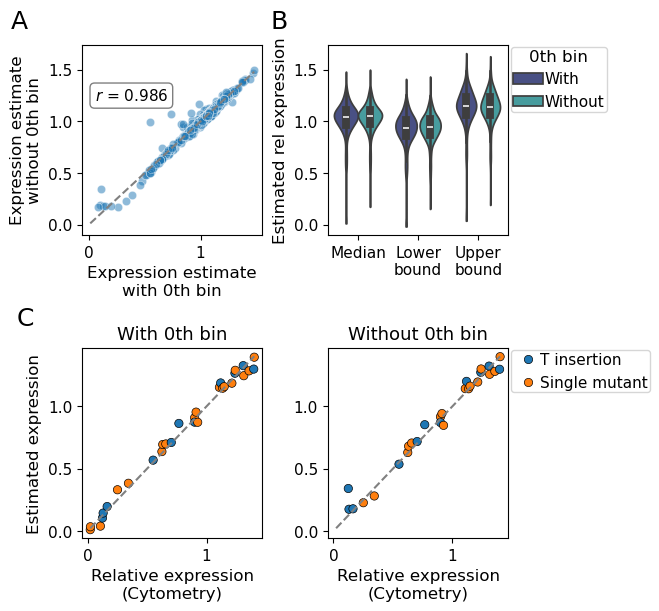

In [131]:
fig, axs = plt.subplots(2, 2, figsize=(6.48, 6), constrained_layout=True)

# Panel A
sns.scatterplot(data=exp_predict_comp, x='Median_rel_exp', y='Median_delta_WT_NoDead', alpha=0.5,
               ax=axs[0,0])
diag_range = np.linspace(np.min(exp_predict_comp['Median_rel_exp']), np.max(exp_predict_comp['Median_rel_exp']), 10)
axs[0,0].plot(diag_range, diag_range, linestyle='--', c='grey')
r_calc = exp_predict_comp.dropna(subset=['Median_rel_exp', 'Median_delta_WT_NoDead']).reset_index(drop=True)
r_comp = stats.pearsonr(r_calc['Median_rel_exp'], r_calc['Median_delta_WT_NoDead'])
axs[0,0].annotate(r"$r$ = "f'{round(r_comp[0], 3)}', (0.05, 1.2), 
                  bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=11)
axs[0,0].set_ylabel('Expression estimate\nwithout 0th bin')
axs[0,0].set_xlabel('Expression estimate\nwith 0th bin')

# Panel B
violins_0th = sns.violinplot(data=dist_comp, x='Exp estimate', y='Expression level', hue='0th bin', cut=0, ax=axs[0,1], dodge=True,
                            palette='mako')
axs[0,1].sharey(axs[0,0])
h_0th, l_0th = violins_0th.get_legend_handles_labels()
violins_0th.legend(h_0th, l_0th, handletextpad=0.1, title='0th bin', loc="upper left",
                    bbox_to_anchor=(1.0, 1.0), borderaxespad=0.15, borderpad=0.15, fontsize=11, title_fontsize=12)
axs[0,1].set_ylabel('Estimated rel expression')
axs[0,1].set_xlabel('')

# Panel C
sns.scatterplot(data=cyto_pred_comp, x='Relative_median_exp', y='Median_rel_exp', hue='T_insertion', hue_order=['T insertion', 'Single mutant'],
               ax=axs[1,0], legend=False, edgecolor='black')
diag_c = np.linspace(np.min(cyto_pred_comp['Relative_median_exp']), np.max(cyto_pred_comp['Relative_median_exp']), 10)
axs[1,0].plot(diag_c, diag_c, linestyle='--', c='grey')
axs[1,0].set_title('With 0th bin', fontsize=13)
axs[1,0].set_ylabel('Estimated expression')
axs[1,0].set_xlabel('Relative expression\n(Cytometry)')

# Panel D
scatter_noDead = sns.scatterplot(data=cyto_pred_comp, x='Relative_median_exp', y='Median_delta_WT_NoDead', hue='T_insertion', hue_order=['T insertion', 'Single mutant'],
                                 ax=axs[1,1], edgecolor='black')
axs[1,1].sharey(axs[1,0])
h_scatter, l_scatter= scatter_noDead.get_legend_handles_labels()
scatter_noDead.legend(h_scatter, l_scatter, title='', loc="upper left",
                      bbox_to_anchor=(1.0, 1.0), fontsize=11, title_fontsize=12,
                      handletextpad=-0.25, borderaxespad=0.15, borderpad=0.15, scatteryoffsets=[0.65])
axs[1,1].plot(diag_c, diag_c, linestyle='--', c='grey')
axs[1,1].set_title('Without 0th bin', fontsize=13)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Relative expression\n(Cytometry)')

# Annotating the panels
axs[0,0].annotate('a', (-0.7, 1.90), annotation_clip=False, fontsize=18)
axs[0,1].annotate('b', (-1.45, 1.90), annotation_clip=False, fontsize=18)
axs[1,0].annotate('c', (-0.595, 1.65), annotation_clip=False, fontsize=18)

FigS17 = plt.gcf()
FigS17.savefig('Supp_figs/S17Fig.tiff', bbox_inches='tight', dpi=600)

## Comparing the effect of single mutants to the deletion of complete putative regulatory sites

We deleted these two regions:

- -133 to -127
- -125 to -118

### Making S18 Fig 

In [162]:
# Shortening mutation types
sort_comp['Mutation type'] = sort_comp['Mutation type'].apply(lambda x: mut_rename[x])

mut_palette = {'Sub': cm.tab10.colors[9], 
               'Ins': cm.tab20b.colors[1],
               'Del': cm.tab10.colors[3]}

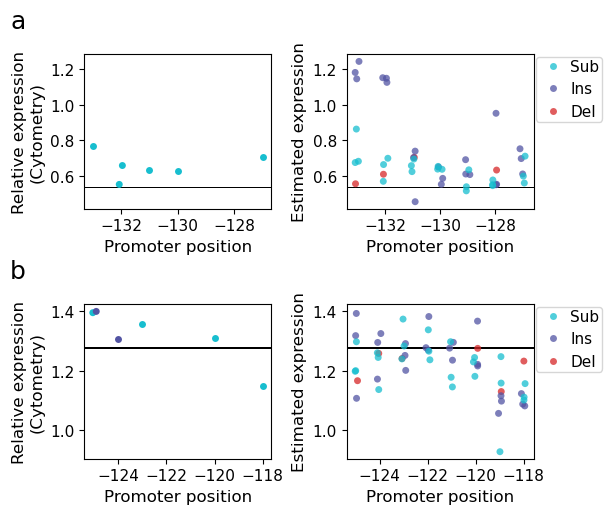

In [170]:
fig, axs = plt.subplots(2, 2, figsize=(6, 5), constrained_layout=True)

# Panel A: site -133 to -127, only validation mutants
sns.stripplot(data=sort_comp[(sort_comp['FCY1_position'] >= -133) & (sort_comp['FCY1_position'] <= -127)],
              x='FCY1_position', y='Relative_median_exp', hue='Mutation type', palette=mut_palette, native_scale=True,
              ax=axs[0,0], legend=False)
axs[0,0].sharey(axs[0,1])
axs[0,0].set_ylabel('Relative expression\n(Cytometry)')
axs[0,0].set_xlabel(r"Promoter position")

top_all = sns.stripplot(data=exp_predict_comp[(exp_predict_comp['FCY1_position'] >= -133) & (exp_predict_comp['FCY1_position'] <= -127)],
                        x='FCY1_position', y='Median_rel_exp', hue='Mutation type', palette=mut_palette, native_scale=True, alpha=0.75,
                        ax=axs[0,1], hue_order=['Sub', 'Ins', 'Del'])

h_top, l_top = top_all.get_legend_handles_labels()
top_all.legend(h_top, l_top, handletextpad=0.1, loc="upper left",
               bbox_to_anchor=(1.0, 1.0), borderaxespad=0.15, borderpad=0.15, fontsize=11, title_fontsize=12)
axs[0,1].set_ylabel('Estimated expression')
axs[0,1].set_xlabel(r"Promoter position")

# Adding the cytometry measurements for the deletion of the site
for ax in [axs[0,0], axs[0,1]]:
    #ax.axhline(y=rel_exp_med[rel_exp_med['Genotype']=='Deletion_site-133to-127']['Relative_median_exp'].values[0],
               #linestyle='--', color='black')
    xlims = ax.get_xlim()
    min_exp = rel_exp_med[rel_exp_med['Genotype']=='Deletion_site-133to-127']['Min_rel_exp'].values[0]
    max_exp = rel_exp_med[rel_exp_med['Genotype']=='Deletion_site-133to-127']['Max_rel_exp'].values[0]
    ax.add_patch(Rectangle((xlims[0], min_exp), (xlims[1] - xlims[0]), (max_exp - min_exp), facecolor='black',
                           edgecolor=None, alpha=1.0))

# Panel B: site -125 to -118, only validation mutants
sns.stripplot(data=sort_comp[(sort_comp['FCY1_position'] >= -125) & (sort_comp['FCY1_position'] <= -118)],
              x='FCY1_position', y='Relative_median_exp', hue='Mutation type', palette=mut_palette, native_scale=True,
              ax=axs[1,0], legend=False)
axs[1,0].sharey(axs[1,1])
axs[1,0].set_ylabel('Relative expression\n(Cytometry)')
axs[1,0].set_xlabel(r"Promoter position")

bot_all = sns.stripplot(data=exp_predict_comp[(exp_predict_comp['FCY1_position'] >= -125) & (exp_predict_comp['FCY1_position'] <= -118)],
                        x='FCY1_position', y='Median_rel_exp', hue='Mutation type', palette=mut_palette, native_scale=True, alpha=0.75,
                        ax=axs[1,1], hue_order=['Sub', 'Ins', 'Del'])
axs[1,1].set_ylabel('Estimated expression')
axs[1,1].set_xlabel(r"Promoter position")

h_bot, l_bot = bot_all.get_legend_handles_labels()
bot_all.legend(h_bot, l_bot, handletextpad=0.1, loc="upper left",
               bbox_to_anchor=(1.0, 1.0), borderaxespad=0.15, borderpad=0.15, fontsize=11, title_fontsize=12)

# Adding the cytometry measurements for the deletion of the site
for ax in [axs[1,0], axs[1,1]]:
    #ax.axhline(y=rel_exp_med[rel_exp_med['Genotype']=='Deletion_site -125to-118']['Relative_median_exp'].values[0],
              #linestyle='--', color='black')
    xlims = ax.get_xlim()
    min_exp = rel_exp_med[rel_exp_med['Genotype']=='Deletion_site -125to-118']['Min_rel_exp'].values[0]
    max_exp = rel_exp_med[rel_exp_med['Genotype']=='Deletion_site -125to-118']['Max_rel_exp'].values[0]
    ax.add_patch(Rectangle((xlims[0], min_exp), (xlims[1] - xlims[0]), (max_exp - min_exp), facecolor='black',
                           edgecolor=None, alpha=1.0))

# Annotating each panel
axs[0,0].annotate('a', (-53.5, 130), fontsize=18, xycoords='axes points', annotation_clip=False)
axs[1,0].annotate('b', (-53.5, 130), fontsize=18, xycoords='axes points', annotation_clip=False)

FigS18 = plt.gcf()
FigS18.savefig('Supp_figs/S18Fig.tiff', bbox_inches='tight', dpi=600)